In [1]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import datetime
from catboost import CatBoostClassifier
import lightgbm as lgb
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import ast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model

from tqdm import tqdm_notebook as tqdm
import gc, pickle

import datetime
from catboost import CatBoostClassifier
from time import time
from collections import Counter
from scipy import stats

from sklearn import preprocessing

In [2]:
def create_is_sell_data(sell_prices_df, calendar_df, train_df):
    sell_prices_df['id'] = sell_prices_df['item_id'].astype('str')+'_'+sell_prices_df['store_id']+'_validation'
    sell_prices_data = sell_prices_df[sell_prices_df.wm_yr_wk.isin(calendar_df.wm_yr_wk.unique())]
    sell_prices_data.reset_index(drop=True, inplace=True)
    tmp = sell_prices_data.groupby(['id'])[['wm_yr_wk', 'sell_price']].apply(lambda x: x.set_index('wm_yr_wk')['sell_price'].to_dict()).to_dict()
    d = calendar_df.d
    wm_yr_wk = calendar_df.wm_yr_wk
    price_data = {}
    for col in tqdm(train_df.id.unique()):
        price_data[col] = wm_yr_wk.map(tmp[col])
    price_data = pd.DataFrame(price_data)
    price_data.index = d
    is_sell = price_data.notnull().astype(float).T
    price_data = price_data.fillna(0)
    
    is_sell.index=train_df.id
    train_df.index=train_df.id
    is_sell = pd.concat([
        train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']], is_sell
    ], axis=1)
    price_data = pd.concat([
        train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']], price_data.T  
    ], axis=1)
    
    return price_data, is_sell

def set_index(df, name):
    d = {}
    for col, value in df.iloc[0,:].items():
        if type(col)==str:
            if 'level' in col:
                v = 'd'
            else:
                v='id'
        else:
            v=name
        d[col]=v
    return d

def dcol2int(col):
    if col[:2]=='d_':
        return int(col.replace('d_', ''))
    else:
        return col

In [3]:
def create_category_data(data, dfT):
    C = ['item_id', 'cat_id', 'dept_id']
    tmp = dfT[C]
    for c in C:
        tmp[c] = tmp[c]
    tmp = tmp.to_dict()
    for key, value in tmp.items():
        data[key] = data.id.map(value)
    return data
def create_calendar_data_dict(calendar_df, use_d_cols, _store):
    calendar_data_dict = {}
    calendar_data_dict.update(
        calendar_df[calendar_df.d.isin(use_d_cols)][['wday', 'month', f'snap_{_store[:2]}']].to_dict()
    )
    
    for shift in [0,1]:
        tmp = calendar_df[calendar_df.d.isin(use_d_cols)][[f'snap_{_store[:2]}']].shift(shift)
        tmp=tmp.rename(columns={f'snap_{_store[:2]}':f'snap_{_store[:2]}_shift{shift}'})
        calendar_data_dict.update(tmp.to_dict())
        
    return calendar_data_dict

def tmp_a_calendar_data(train_df):
    a = train_df.groupby(['store_id', 'dept_id'])[d_cols].agg('mean').T.astype(float)
    a.columns = [f'{c1}_and_{c2}' for c1, c2 in a.columns]
    a = a/a.rolling(len(a), min_periods=1).mean()
    a['d'] = a.index
    a.index = a.d
    return a

def create_tmp_data_dict(event_day_dict, a, shift):
    tmp_data_dict={}
    for tmp_days in event_day_dict.values():
        t = a.shift(shift).loc[tmp_days]
        t = t.shift(1).rolling(len(t), min_periods=1).mean()
        t = t.loc[:,t.columns.str.startswith(_store)]
        for col in t.columns:
            for v in t[col].iteritems():
                tmp_data_dict[f'{col}_and_{v[0]}'] = v[1]
    return tmp_data_dict

def create_event_data(data, name, shifts):
    event = calendar_df[name].dropna().unique().tolist()
    event_day_dict={}
    for event_name in event:
        event_day_dict[event_name] = calendar_df[calendar_df[name]==event_name].index.tolist()
    a = tmp_a_calendar_data(train_df)
    
    for shift in shifts:
        tmp_data_dict = create_tmp_data_dict(event_day_dict, a, shift)
        new_col_name = f'{name}_{shift}' if shift>=0 else f'{name}_mns_{-shift}'
        data[new_col_name] = data.store_and_deptid_and_d.map(tmp_data_dict).shift(-shift)
    return data

def create_groupby_price_data(data, store_price_data, use_d_cols, groups=['dept_id', 'cat_id']):
    for group in groups:
        tmp = store_price_data[use_d_cols]/store_price_data.groupby([group])[use_d_cols].transform('mean')
        tmp = tmp.T.astype(float)
        tmp = tmp.rolling(7, min_periods=1).mean().stack(dropna=False).reset_index()
        tmp = tmp.rename(columns=set_index(tmp, f'price_mean_{group}'))
        data = pd.merge(data, tmp, on=['d', 'id'], how='left')
    
    return data

In [4]:
def create_diff_data(data, df, i, wins, use_d_cols, name=None):
    a = df.diff(i)
    for win in wins:
        for agg in ['mean', 'std']:
            tmp = a.rolling(window=win, min_periods=1).agg(agg).loc[use_d_cols].stack(dropna=False).reset_index()
            if name is None:
                tmp = tmp.rename(columns=set_index(tmp, f'diff_{i}_roll{win}_{agg}'))
            else:
                tmp = tmp.rename(columns=set_index(tmp, f'{name}_diff_{i}_roll{win}_{agg}'))
            data = pd.merge(data, tmp, on=['d', 'id'], how='left')
    a = abs(a)
    for win in wins:
        for agg in ['mean', 'std']:
            tmp = a.rolling(window=win, min_periods=1).agg(agg).loc[use_d_cols].stack(dropna=False).reset_index()
            if name is None:
                tmp = tmp.rename(columns=set_index(tmp, f'abs_diff_{i}_roll{win}_{agg}'))
            else:
                tmp = tmp.rename(columns=set_index(tmp, f'{name}_abs_diff_{i}_roll{win}_{agg}'))
            data = pd.merge(data, tmp, on=['d', 'id'], how='left')
    return data

def create_group_sell_data(data, dfT, use_d_cols, groups=['dept_id', 'cat_id']):
    for group in groups:
        tmp = dfT[use_d_cols]/ dfT.groupby([group])[use_d_cols].transform('mean')
        tmp = tmp.T.astype(float)
        data = create_diff_data(data, tmp, 7, wins=[360, 30, 28, 7], use_d_cols=use_d_cols, name=f'By_{group}')
        data = create_diff_data(data, tmp, 1, wins=[360, 7], use_d_cols=use_d_cols, name=f'By_{group}')
        data = create_diff_data(data, tmp, 28, wins=[360, 7], use_d_cols=use_d_cols, name=f'By_{group}')
    return data


def create_shift_data(data, df, shifts, use_d_cols, name=None):
    for i, shift in enumerate(shifts):
        tmp = df.shift(shift).loc[use_d_cols].stack(dropna=False).reset_index()
        if name is None:
            tmp = tmp.rename(columns=set_index(tmp, f'shift_no{i+1}'))
        else:
            tmp = tmp.rename(columns=set_index(tmp, f'{name}_shift_no{i+1}'))
        data = pd.merge(data, tmp, on=['d', 'id'], how='left')
    return data

def create_group_shift_data(data, dfT, shifts, use_d_cols):
    for group in ['dept_id', 'cat_id']:
        tmp = dfT.groupby([group])[use_d_cols].transform('mean').T.astype(float)
        data = create_shift_data(data, tmp, shifts, use_d_cols, name=f'By_{group}')
    return data

In [5]:
def make_input(train_d_cols, _store):
    use_d_cols = [i for i in range(train_d_cols[0]-380,train_d_cols[0])]+train_d_cols
    ids = train_df[train_df.store_id==_store].id.unique().tolist()
    
    df = train_df.loc[ids,:]
    df = df.T.loc[d_cols]
    df = pd.DataFrame(df.values.astype(float), index=d_cols, columns=df.columns)

    df['d']=df.index
    calendar_dict = calendar_df[[
        'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1',
        'event_type_1', 'event_name_2', 'event_type_2',f'snap_{_store[:2]}'
    ]].set_index('d').to_dict()

    for key, value in calendar_dict.items():
        df[key] = df['d'].map(value)
    df.drop('d', axis=1, inplace=True)
    
    store_price_data = price_data.loc[ids,:]
    store_is_sell = is_sell.loc[ids,:]
    store_price_data[[col for col in store_price_data.columns if type(col)!=str]] =\
            store_price_data[[col for col in store_price_data.columns if type(col)!=str]].replace(0, np.nan)
    
    
    df = df.loc[use_d_cols]
    dfT = train_df.loc[ids,['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']+use_d_cols]
    store_is_sell = store_is_sell[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']+use_d_cols]
    store_price_data = store_price_data[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']+use_d_cols]
    
    data = pd.concat([
        df.loc[train_d_cols, ids].stack(dropna=False).reset_index().rename(columns={'level_0':'d', 'id':'id', 0:'TARGET'})
    ], axis=0)
    
    
    data = fe(data, ids, df, dfT, store_price_data, calendar_df, use_d_cols, train_d_cols, _store)
    
    return data

def fe(data, ids, df, dfT, store_price_data, calendar_df, use_d_cols, train_d_cols, _store):
    data = create_category_data(data, dfT)
    
    calendar_data_dict = create_calendar_data_dict(calendar_df, use_d_cols, _store)
    for key, values in calendar_data_dict.items():
        data[key] = data.d.map(values)

    data['store_and_deptid_and_d'] = _store+'_and_'+data.dept_id+'_and_'+data.d.astype(str)

    data = create_event_data(data, 'event_name_1', [-3,-2,-1,0,1,2,3])
    data = create_event_data(data, 'event_name_2', [-3,-2,-1,0,1,2,3])

    data['event_type_1_0'] = data.d.map(calendar_df['event_type_1'])
    data['event_type_2_0'] = data.d.map(calendar_df['event_type_2'])
    for i in [-3,-2,-1,1,2,3]:
        new_col_name = f'event_type_1_{i}' if i>=0 else f'event_type_1_mns_{-i}'
        data[new_col_name] = data.event_type_1_0.shift(i)
        new_col_name = f'event_type_2_{i}' if i>=0 else f'event_type_2_mns_{-i}'
        data[new_col_name] = data.event_type_2_0.shift(i)

    data = create_groupby_price_data(data, store_price_data, use_d_cols)
    
    data = create_diff_data(data, df[ids], 7, wins=[360, 30, 28, 7], use_d_cols=train_d_cols)
    data = create_diff_data(data, df[ids], 1, wins=[360, 7], use_d_cols=train_d_cols)
    data = create_diff_data(data, df[ids], 28, wins=[360, 7], use_d_cols=train_d_cols)
    data = create_group_sell_data(data, dfT, use_d_cols, groups=['dept_id', 'cat_id'])
    
    categories = [
        'item_id', 'cat_id', 'dept_id',
        'event_type_1_0', 'event_type_2_0', 'event_type_1_mns_3', 'event_type_2_mns_3', 'event_type_1_mns_2',
        'event_type_2_mns_2', 'event_type_1_mns_1', 'event_type_2_mns_1', 'event_type_1_1',
        'event_type_2_1', 'event_type_1_2', 'event_type_2_2', 'event_type_1_3', 'event_type_2_3'
    ]
    for c in categories:
        data[c] = pd.factorize(data[c])[0]

    del data['store_and_deptid_and_d']
    
    return data, df, dfT

In [12]:
def train(data, df, dfT):
    train_d_cols = data.d.unique().tolist()
    use_d_cols = [i for i in range(train_d_cols[0]-380,train_d_cols[0])]+train_d_cols
    log = []
    for for_predict in range(28):
        print("""
        #########################################
           ##############  {}  ##############
        #########################################""".format(for_predict+1))
        
        g_for_predict = for_predict//7 + 1
        shifts = [7*i for i in range(g_for_predict, g_for_predict+4)]
        
        if for_predict%7==0:
            if for_predict>0:
                data.drop(columns=shift_cols, inplace=True)
            data = create_shift_data(data, df, shifts, use_d_cols)
            data = create_group_shift_data(data, dfT, shifts, use_d_cols)
                
        
        diff_cols = [col for col in data.columns if ('diff' in col)]
        shift_cols = [col for col in data.columns if ('shift' in col) and (not 'diff' in col)and (not 'snap' in col)]
        data = pd.concat([
            data.drop(columns=diff_cols),
            data.groupby(['id'])[diff_cols].transform(
                lambda x: x.sort_index().shift(1)
            )
        ], axis=1)
        
        data =pd.concat([
            data['id'],
            data[[c for c in data.columns if c!='id']].astype(float)
        ], axis=1)
        
        y_df = pd.DataFrame()
        
        y = data[['TARGET']+['d', 'id']]
        X = data.drop(columns=['id', 'TARGET']).astype(float)
        
        split=int(0.3*len(train_d_cols[shifts[0]:]))
        x_train, x_val = X[X.d.isin(train_d_cols[shifts[0]:-split])], X[X.d.isin(train_d_cols[-split:])]
        y_train, y_val = y[y.d.isin(train_d_cols[shifts[0]:-split])], y[y.d.isin(train_d_cols[-split:])]
        y_df['d'] = x_val.d
        y_df['id'] = y_val.id
        x_train.drop('d', axis=1, inplace=True)
        x_val.drop('d', axis=1, inplace=True)
        y_train = y_train['TARGET'].astype(float)
        y_val = y_val['TARGET'].astype(float)
        if for_predict==0:
            print(x_train.shape)
            print(x_val.shape)
        
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(
                    train_set=train_set, 
                    valid_sets=[train_set, val_set],
                    params=params, num_boost_round=3000, early_stopping_rounds=100, verbose_eval=500,
            categorical_feature=categories+['wday', 'month']
        )
        
        y_df['TARGET'] = y_val
        y_df['pred'] = model.predict(x_val)
        importance = pd.DataFrame()
        importance['importance'] = model.feature_importance(importance_type='gain')
        importance['importance'] = preprocessing.minmax_scale(importance.importance)
        importance['columns'] = x_val.columns
        log.append([y_df,importance])
        gc.collect()
        del train_set, val_set, X, x_train, x_val, y_train, y_val;gc.collect()
    gc.collect()
    
    with open(f'train_log_{_store}.pickle', 'wb') as f:
        pickle.dump(log, f)

def plot_importance(model, col, num):
    importance = pd.DataFrame()
    importance['importance'] = model.feature_importance(importance_type='gain')
    importance['importance'] = preprocessing.minmax_scale(importance.importance)
    importance.index = col
    importance = importance['importance']

    plt.figure(figsize=(10,30))
    importance.sort_values( ascending=True).plot('barh')
    plt.title(f'for {num}')
    
def train_predict(data, df, dfT, _store):
    train_d_cols = data[data.TARGET.notnull()].d.unique().tolist()
    use_d_cols = [i for i in range(train_d_cols[0]-380,train_d_cols[0])]+data.d.unique().tolist()
    ids = data.id.unique().tolist()
    
    sub_df = pd.DataFrame()
    #sub_df.index = ids
    models = {}
    for for_predict in range(28):
        print("""
        #########################################
           ##############  {}  ##############
        #########################################""".format(for_predict+1))
        
        g_for_predict = for_predict//7 + 1
        shifts = [7*i for i in range(g_for_predict, g_for_predict+4)]
        
        if for_predict%7==0:
            if for_predict>0:
                data.drop(columns=shift_cols, inplace=True)
            data = create_shift_data(data, df, shifts, use_d_cols)
            data = create_group_shift_data(data, dfT, shifts, use_d_cols)
                
        
        diff_cols = [col for col in data.columns if ('diff' in col)]
        shift_cols = [col for col in data.columns if ('shift' in col) and (not 'diff' in col)and (not 'snap' in col)]
        data = pd.concat([
            data.drop(columns=diff_cols),
            data.groupby(['id'])[diff_cols].transform(
                lambda x: x.sort_index().shift(1)
            )
        ], axis=1)
        
        data =pd.concat([
            data['id'],
            data[[c for c in data.columns if c!='id']].astype(float)
        ], axis=1)
        
        sub_df = pd.concat([
            sub_df,
            data[data.d==TARGET_D_COLS[for_predict]]
        ],axis=0)
        
        y = data[data.TARGET.notnull()][['TARGET']+['d']].astype(float)
        X = data[data.TARGET.notnull()].drop(columns=['id', 'TARGET']).astype(float)
        
        split=int(0.3*len(train_d_cols[shifts[0]:]))
        x_train, x_val = X[X.d.isin(train_d_cols[shifts[0]:-split])], X[X.d.isin(train_d_cols[-split:])]
        y_train, y_val = y[y.d.isin(train_d_cols[shifts[0]:-split])], y[y.d.isin(train_d_cols[-split:])]
        x_train.drop('d', axis=1, inplace=True)
        x_val.drop('d', axis=1, inplace=True)
        y_train = y_train['TARGET']
        y_val = y_val['TARGET']

        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(
                    train_set=train_set, 
                    valid_sets=[train_set, val_set],
                    params=params, num_boost_round=3000, early_stopping_rounds=100, verbose_eval=500,
            categorical_feature=categories+['wday', 'month']
        )
        
        models[f'{_store}_model_{for_predict+1}']=model
        
        plot_importance(model, x_train.columns, for_predict+1)
        gc.collect()
        
        
        del train_set, val_set, X, y, x_train, x_val, y_train, y_val;gc.collect()
    
    gc.collect()
    
    sub_df.reset_index(drop=True, inplace=True)
    sub_df.to_pickle(f'{_store}_csv.pickle')
    with open(f'models_{_store}.pickle', 'wb') as f:
        pickle.dump(models, f)

In [7]:
%%time
#path = '/Users/kanoumotoharu/Downloads/m5-forecasting-accuracy/'
path = '/Users/abcdm/Downloads/m5-forecasting-accuracy/'
#path = '../input/m5-forecasting-accuracy/'

train_df = pd.read_csv(path+'sales_train_validation.csv')
calendar_df = pd.read_csv(path+'calendar.csv')
sell_prices_df = pd.read_csv(path+'sell_prices.csv')
sample_submission_df = pd.read_csv(path+'sample_submission.csv')


categories = [
    'item_id', 'cat_id', 'dept_id',
    'event_type_1_0', 'event_type_2_0', 'event_type_1_mns_3', 'event_type_2_mns_3', 'event_type_1_mns_2',
    'event_type_2_mns_2', 'event_type_1_mns_1', 'event_type_2_mns_1', 'event_type_1_1',
    'event_type_2_1', 'event_type_1_2', 'event_type_2_2', 'event_type_1_3', 'event_type_2_3'
]


calendar_df['d'] = calendar_df.d.str.replace('d_', '').astype(int)
cols = train_df.columns
cols = [dcol2int(col) for col in cols]
train_df.columns=cols
calendar_df['date']=pd.to_datetime(calendar_df.date)
calendar_df.index = calendar_df.d
price_data, is_sell = create_is_sell_data(sell_prices_df, calendar_df, train_df)

d_cols = [ col for col in train_df.columns if type(col)!=str ]
for i in range(1,29):
    train_df[d_cols[-1]+i]=np.nan
d_cols = [ col for col in train_df.columns if type(col)!=str ]

train_df = pd.concat([
    train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']],
    train_df[d_cols]+is_sell[d_cols].replace(0, np.nan).replace(1, 0)
], axis=1)


Wall time: 35.2 s


In [8]:
params = {
            'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'poisson',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.01,
            'feature_fraction': 0.85,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'random_state':123,
            }

In [9]:
lag=30
TARGET_D_COLS = d_cols[-lag:]

train_d_cols = d_cols[-(lag+160+56):-lag]#+TARGET_D_COLS


        #########################################
           ##############  1  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.01037	valid_1's rmse: 1.8617
[1000]	training's rmse: 1.93912	valid_1's rmse: 1.83832
Early stopping, best iteration is:
[1325]	training's rmse: 1.91287	valid_1's rmse: 1.83639


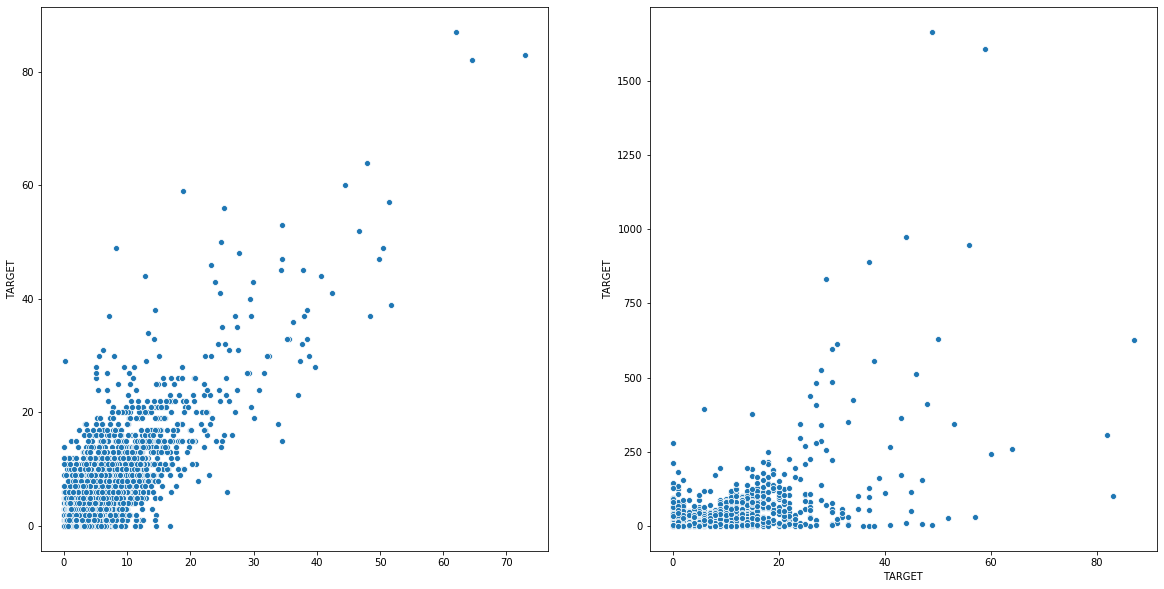


        #########################################
           ##############  2  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.03914	valid_1's rmse: 1.87802
[1000]	training's rmse: 1.96866	valid_1's rmse: 1.86164
Early stopping, best iteration is:
[1012]	training's rmse: 1.96731	valid_1's rmse: 1.86134


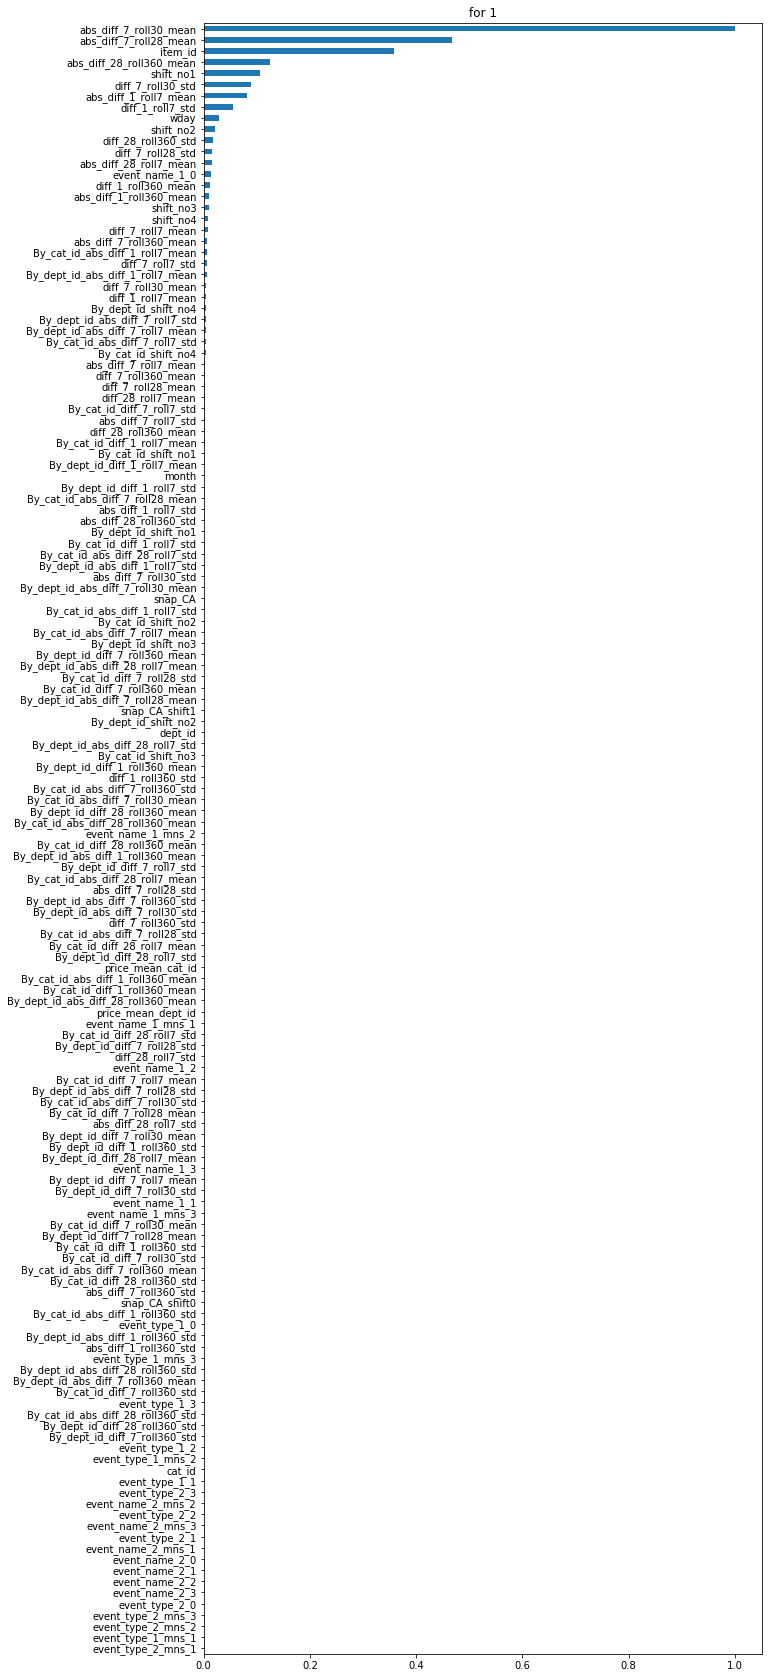

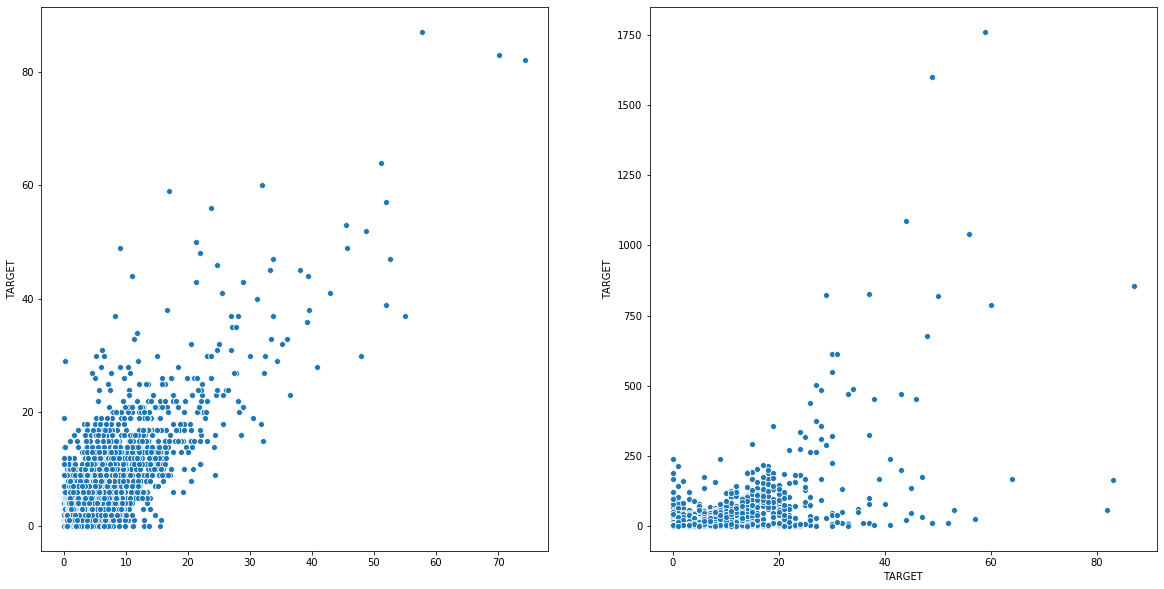


        #########################################
           ##############  3  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.04955	valid_1's rmse: 1.89166
Early stopping, best iteration is:
[846]	training's rmse: 1.99314	valid_1's rmse: 1.87465


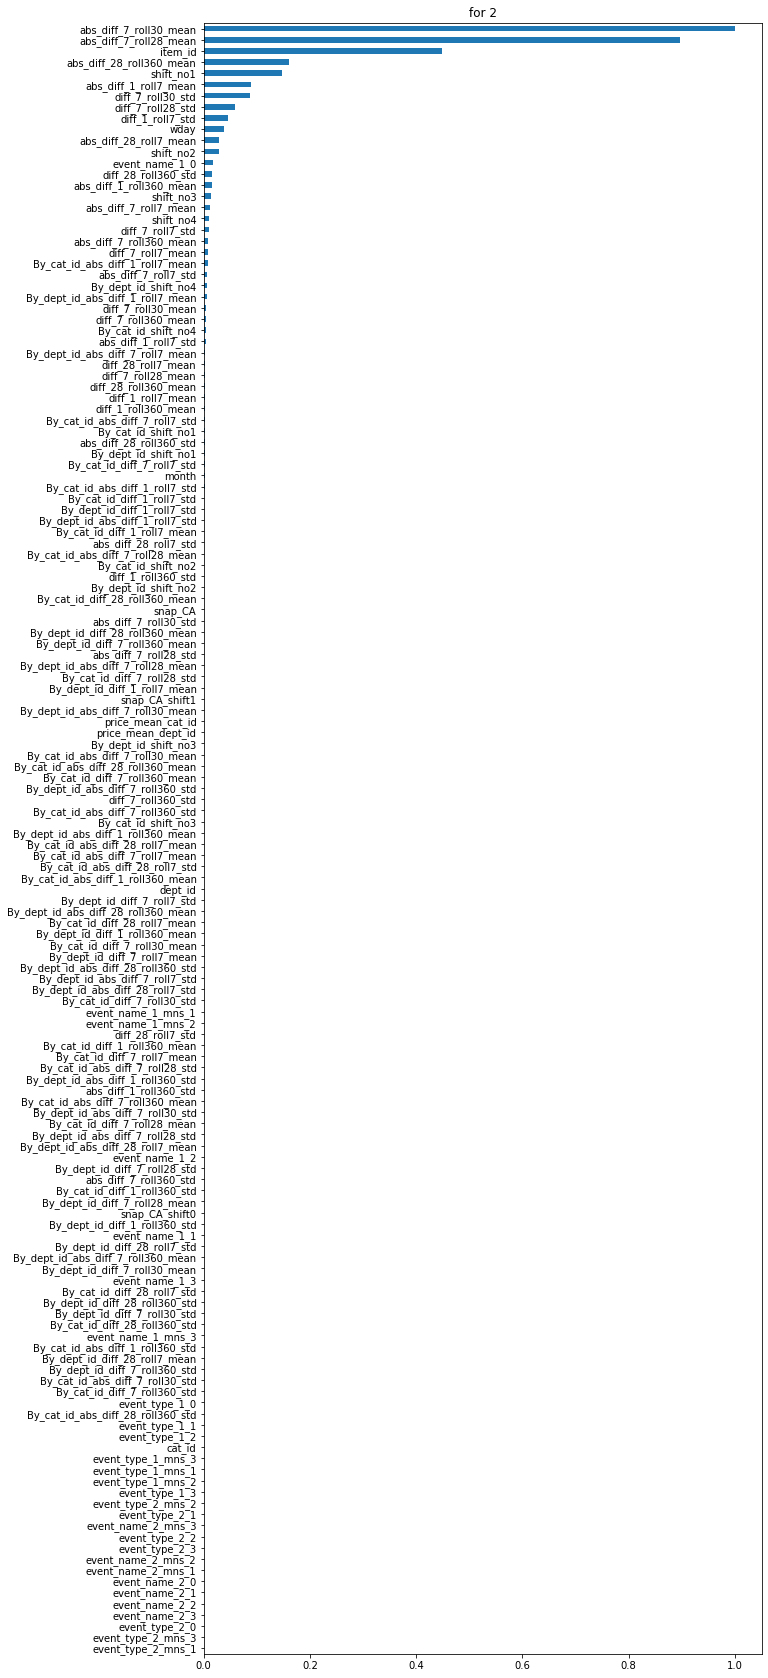

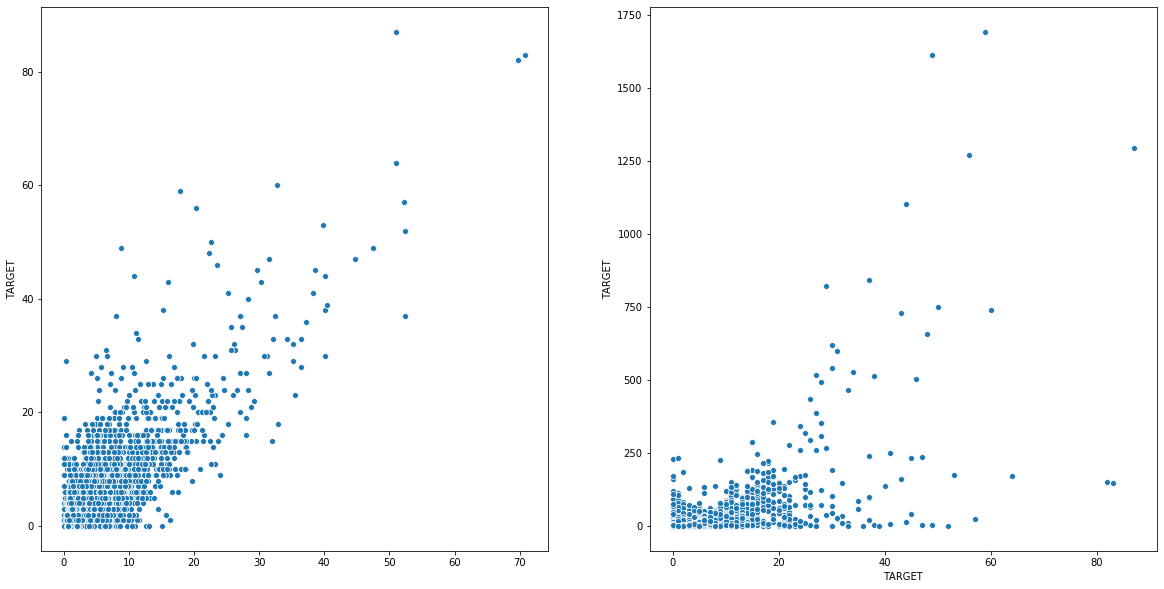


        #########################################
           ##############  4  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.05541	valid_1's rmse: 1.89527
Early stopping, best iteration is:
[810]	training's rmse: 2.0049	valid_1's rmse: 1.87946


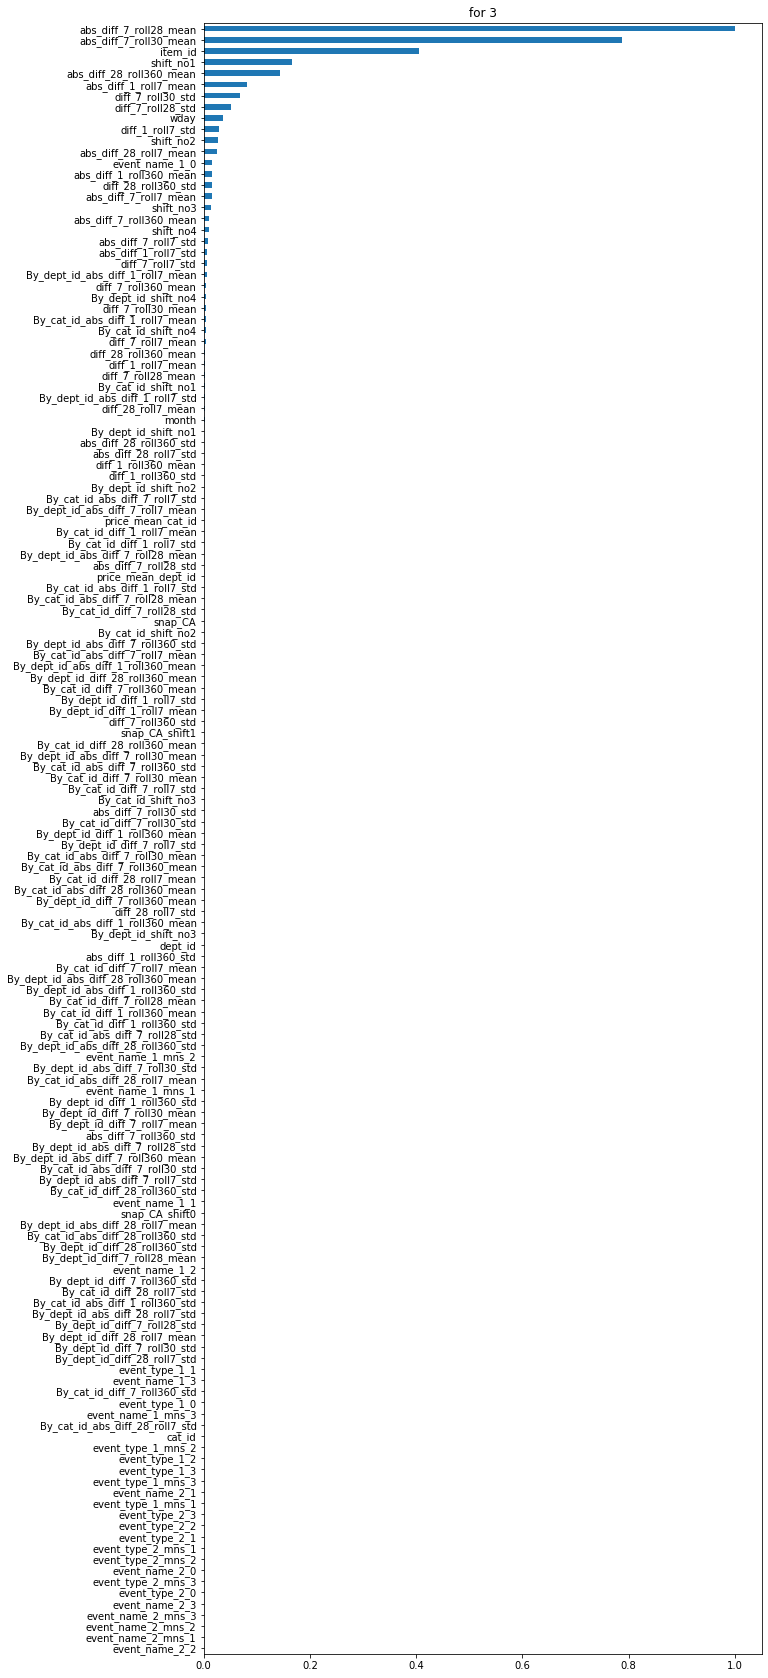

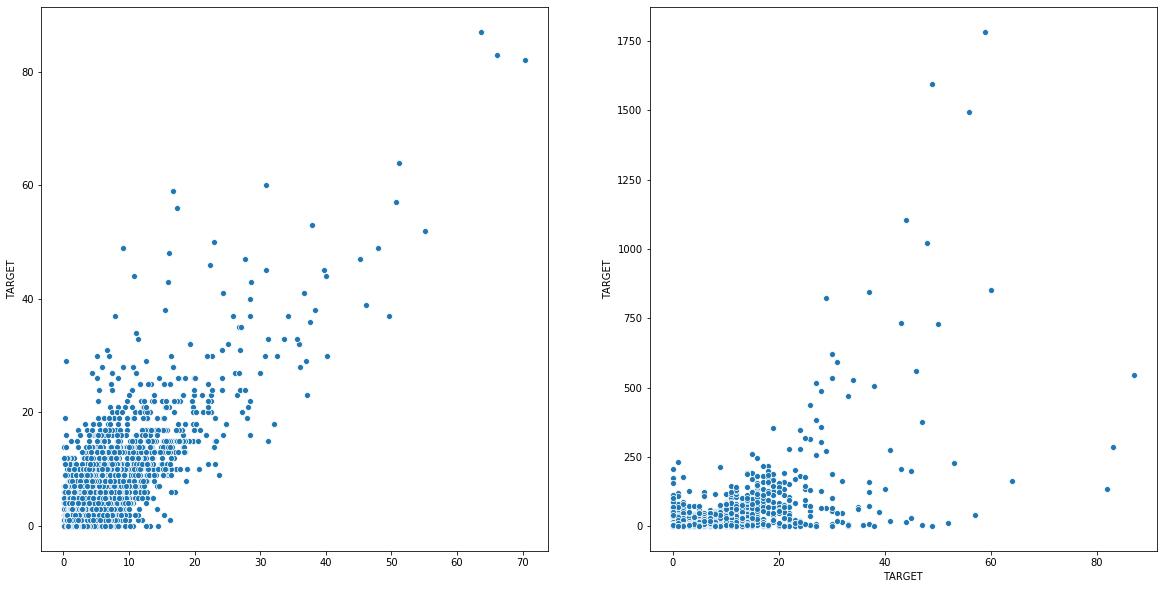


        #########################################
           ##############  5  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.0604	valid_1's rmse: 1.9129
Early stopping, best iteration is:
[794]	training's rmse: 2.01149	valid_1's rmse: 1.90029


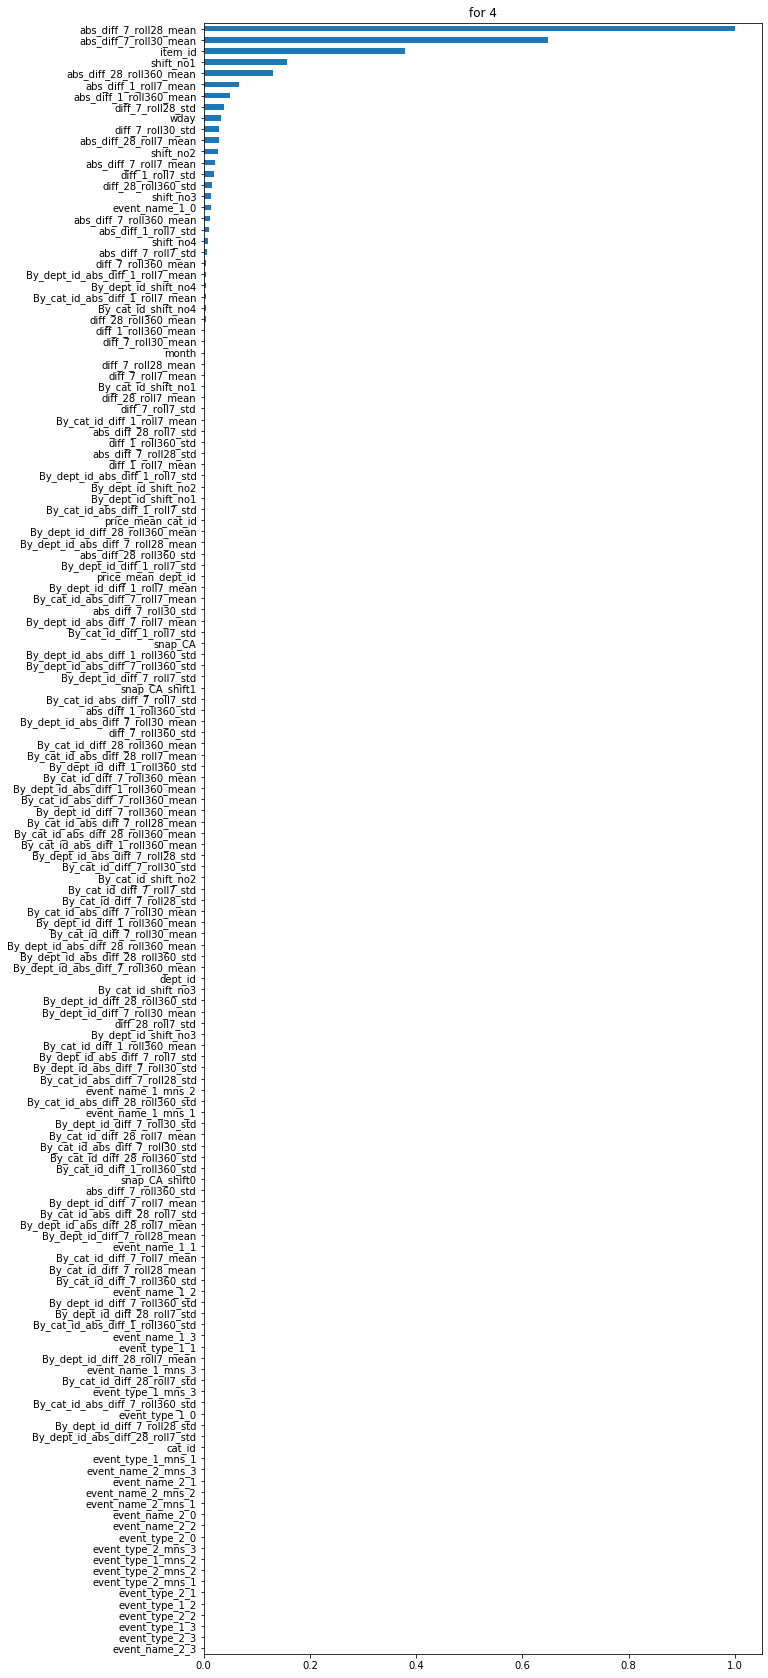

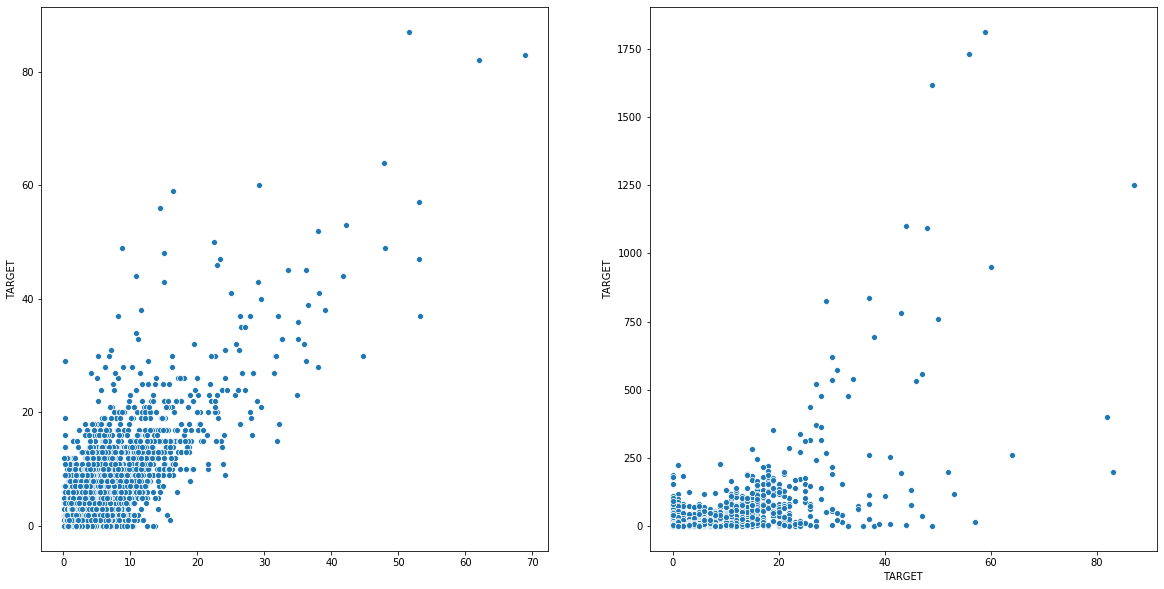


        #########################################
           ##############  6  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.06659	valid_1's rmse: 1.9095
Early stopping, best iteration is:
[809]	training's rmse: 2.01646	valid_1's rmse: 1.89613


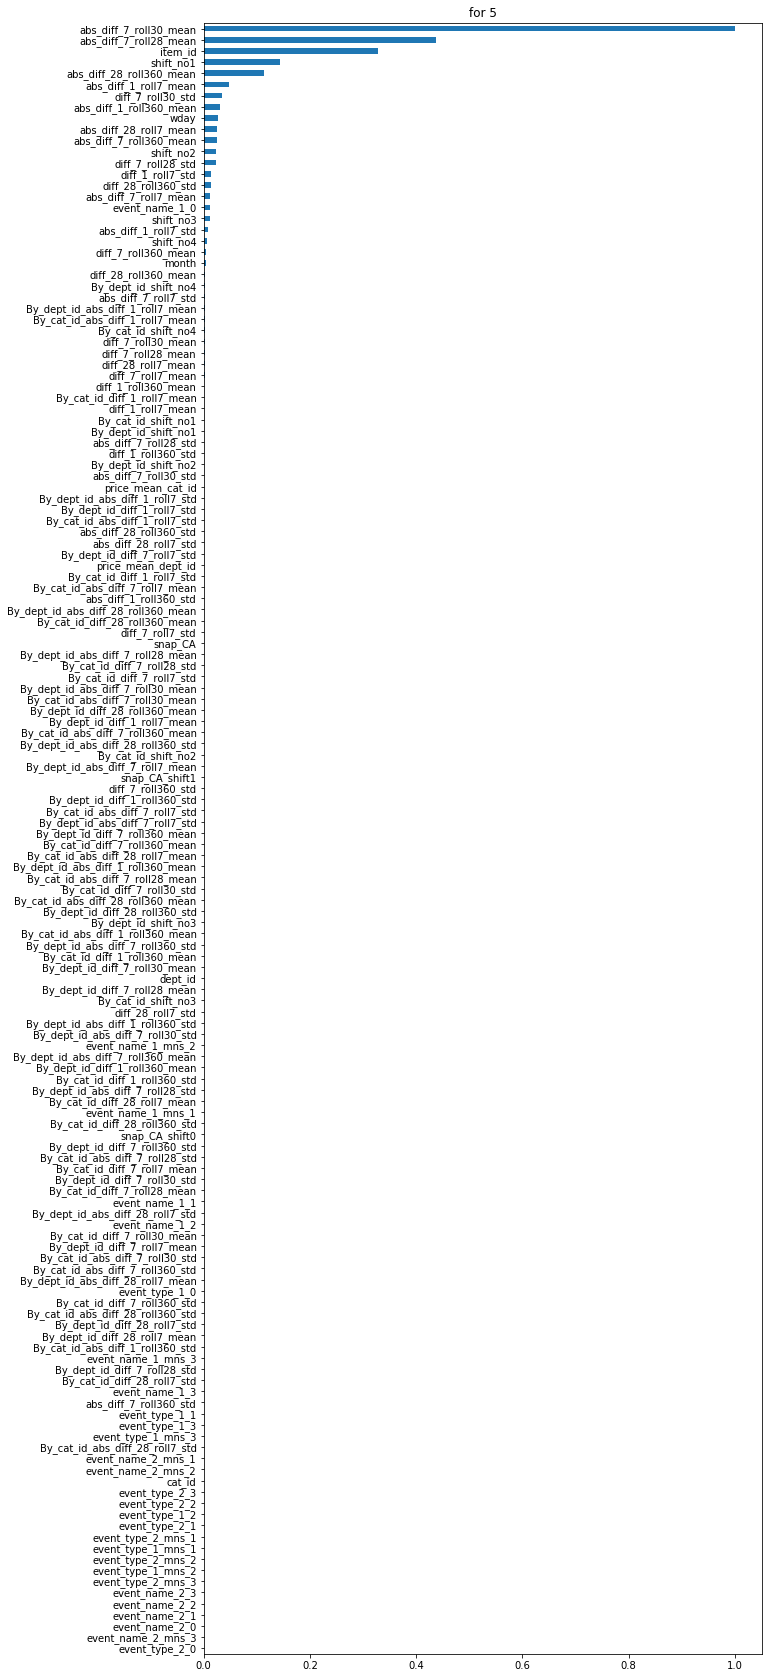

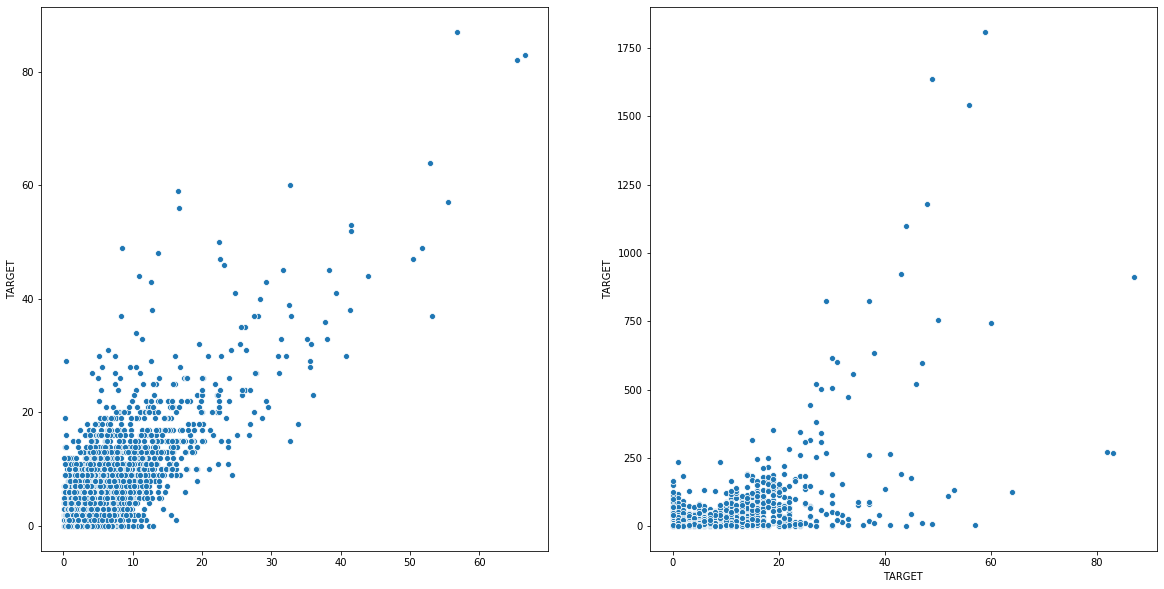


        #########################################
           ##############  7  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.06735	valid_1's rmse: 1.91457
Early stopping, best iteration is:
[871]	training's rmse: 2.01364	valid_1's rmse: 1.89816


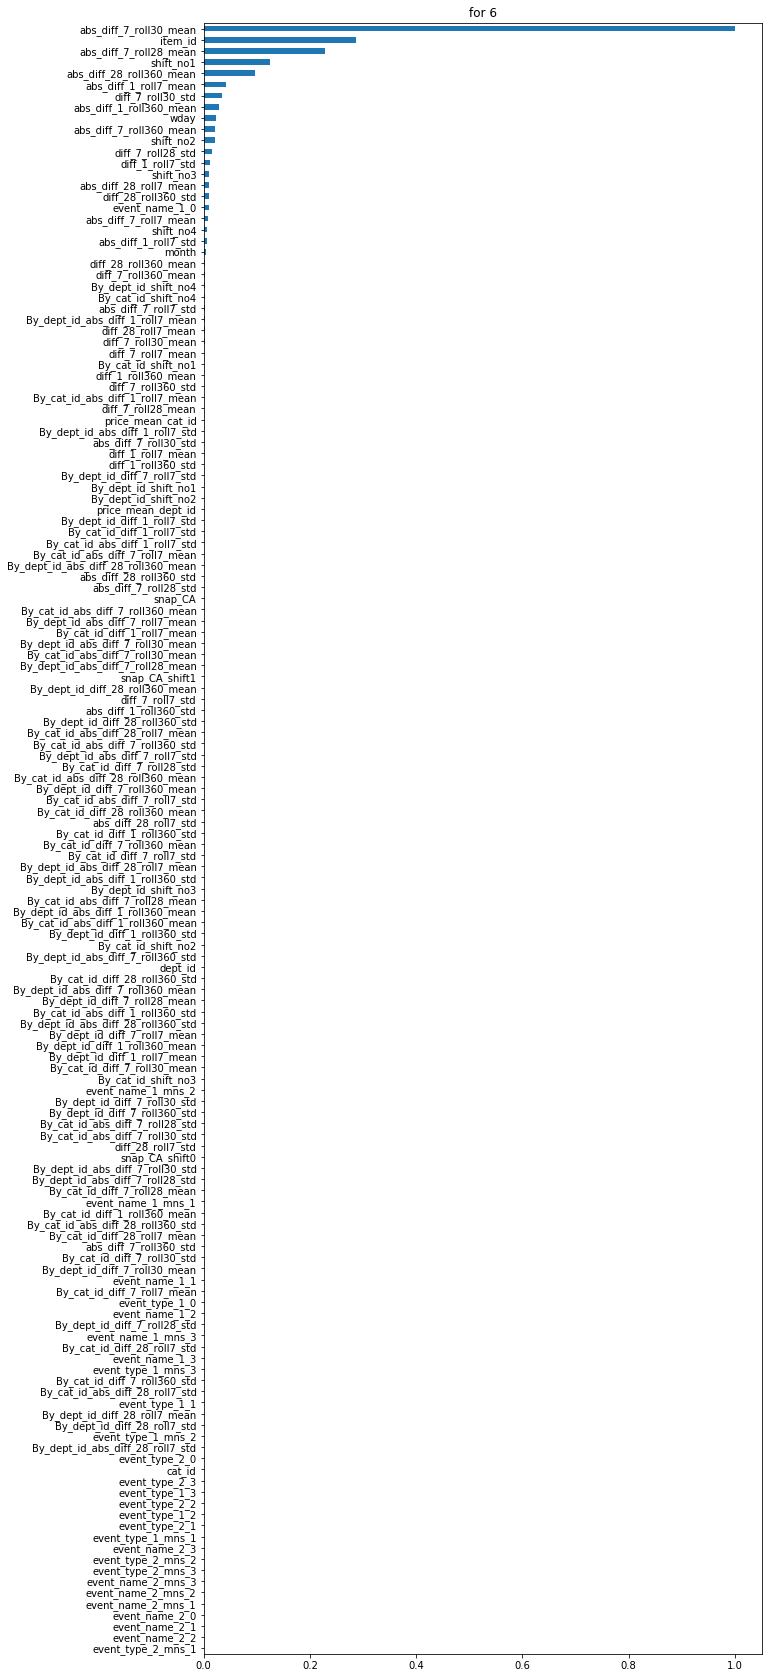

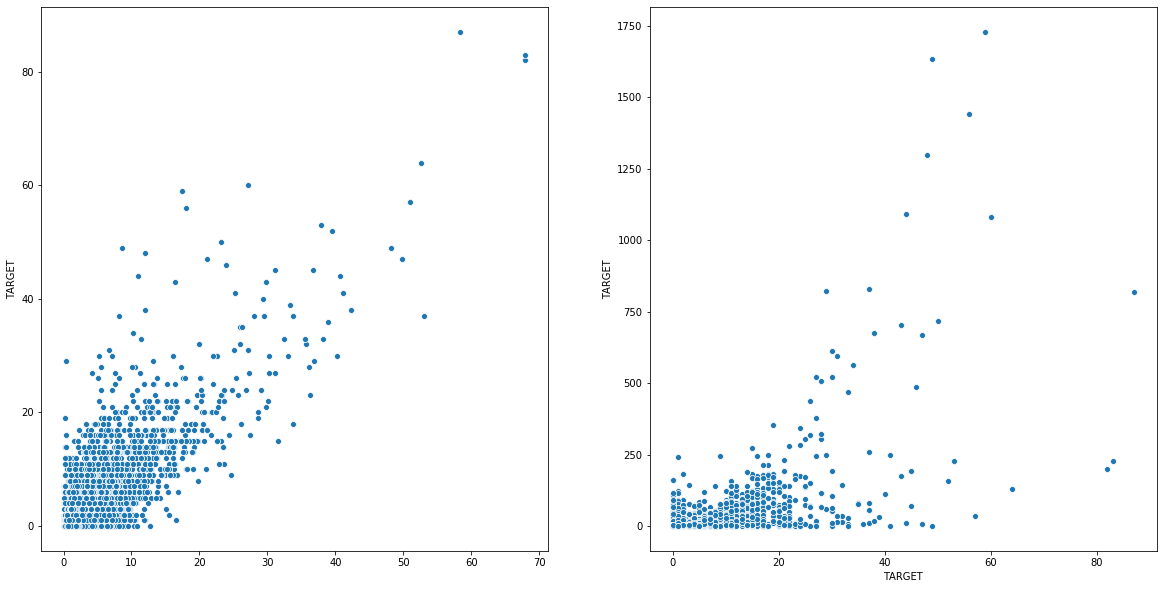


        #########################################
           ##############  8  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.07337	valid_1's rmse: 1.93592
[1000]	training's rmse: 2.00488	valid_1's rmse: 1.9166
Early stopping, best iteration is:
[987]	training's rmse: 2.00605	valid_1's rmse: 1.91636


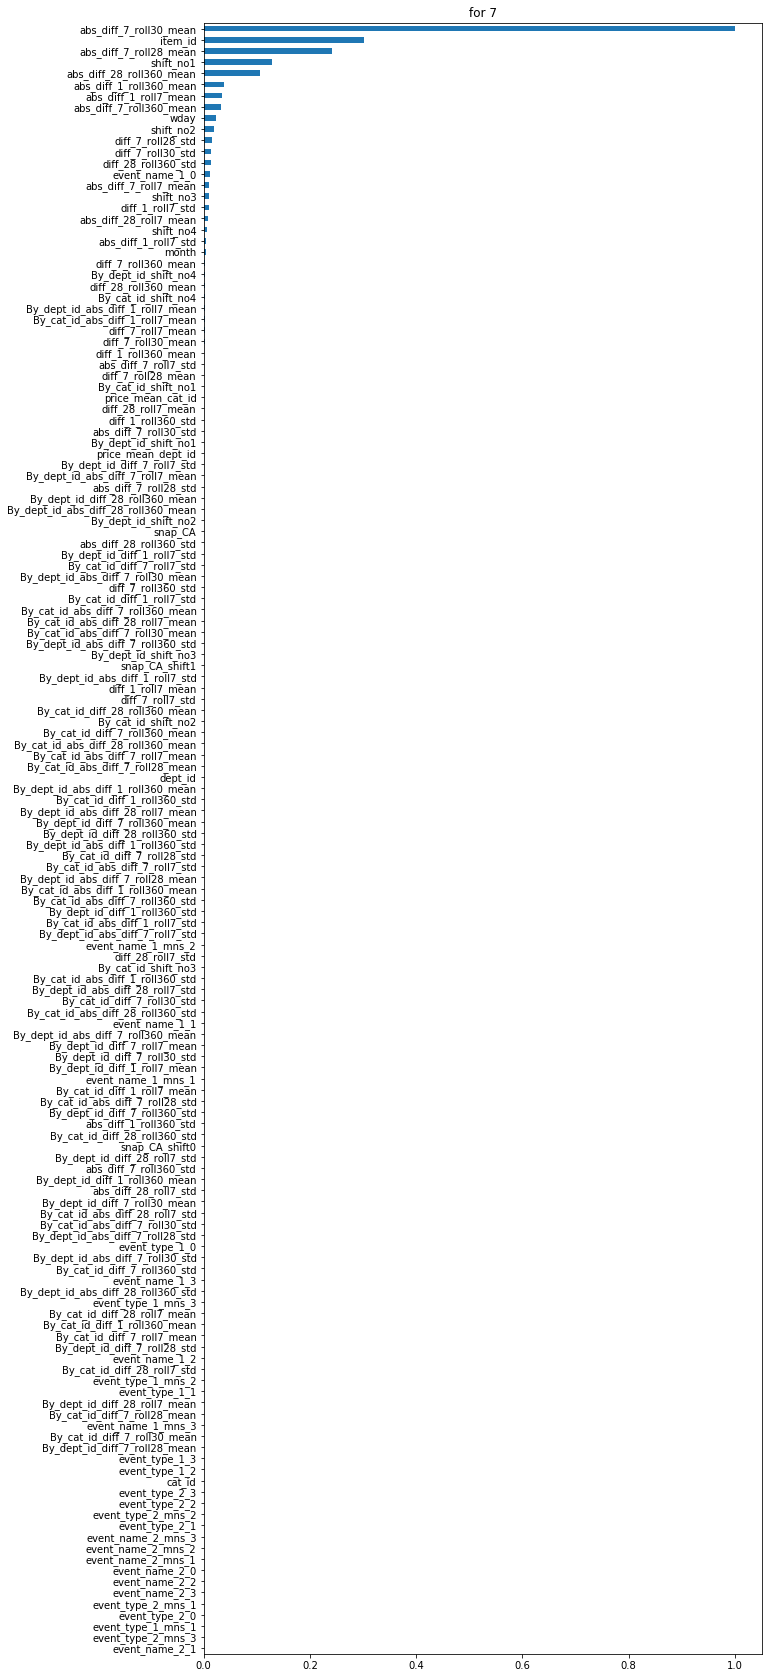

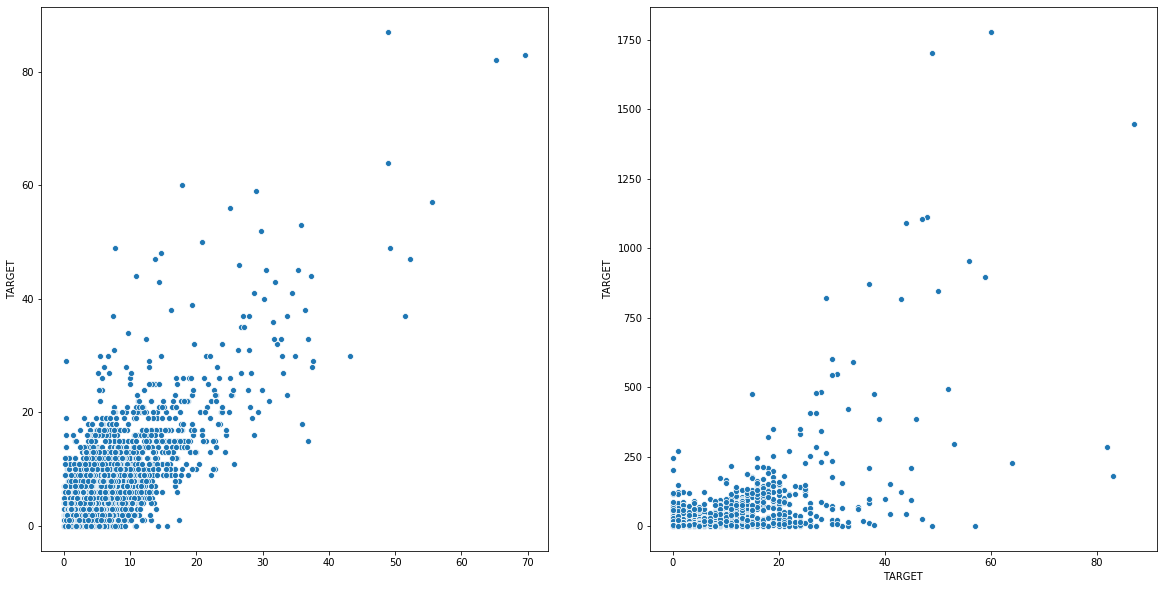


        #########################################
           ##############  9  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.08112	valid_1's rmse: 1.92956
[1000]	training's rmse: 2.0111	valid_1's rmse: 1.91207
Early stopping, best iteration is:
[964]	training's rmse: 2.01431	valid_1's rmse: 1.91143


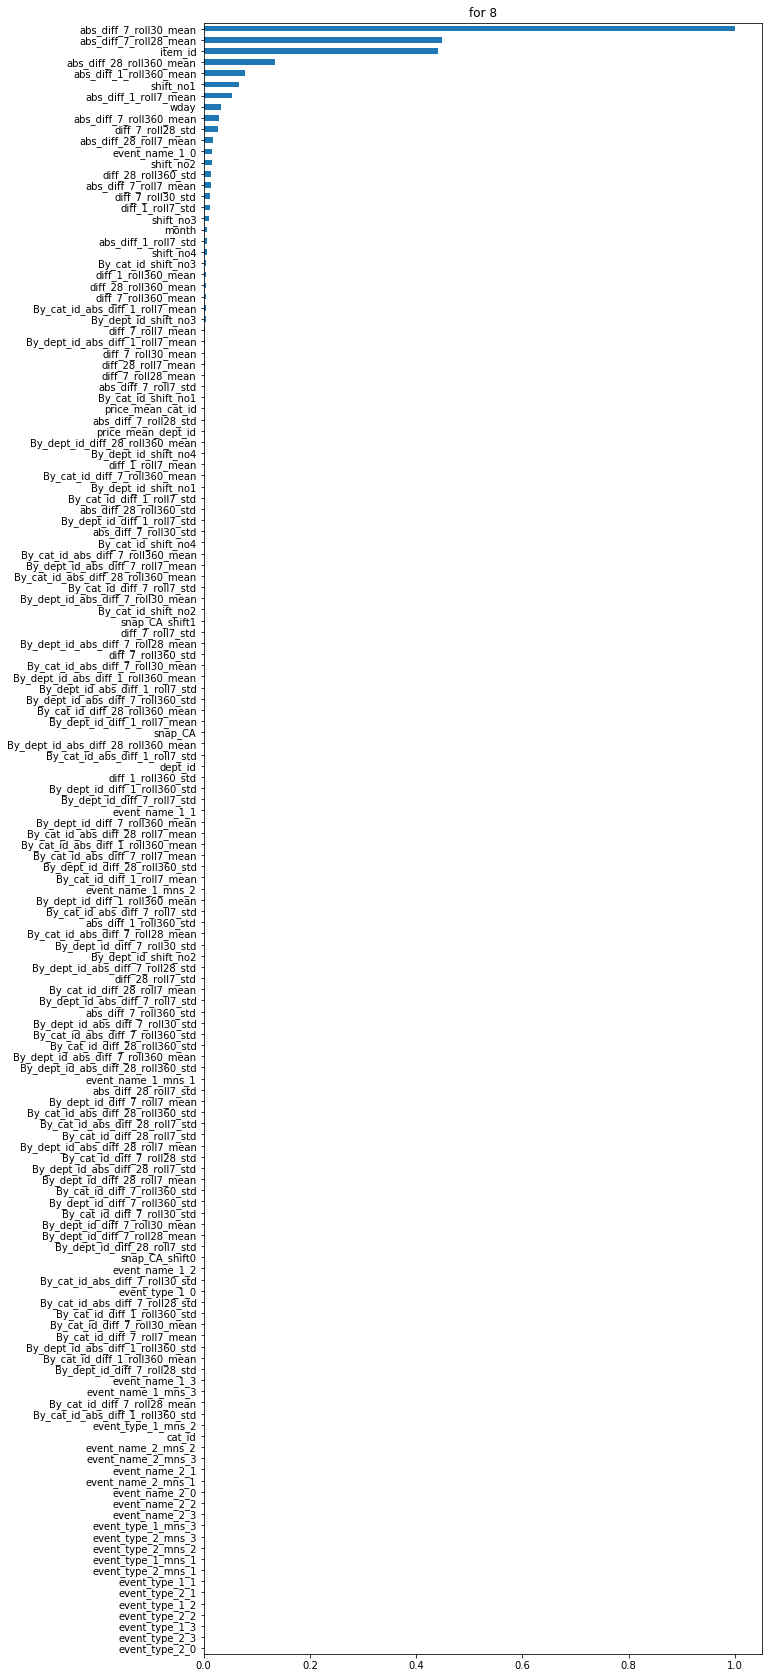

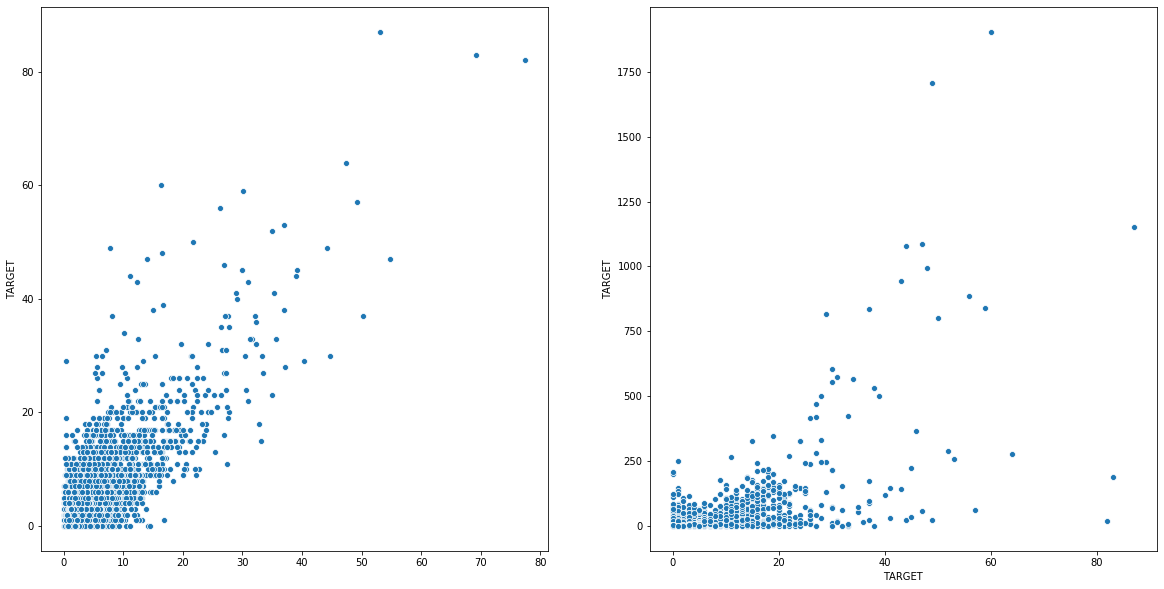


        #########################################
           ##############  10  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.08597	valid_1's rmse: 1.92902
Early stopping, best iteration is:
[814]	training's rmse: 2.03343	valid_1's rmse: 1.91291


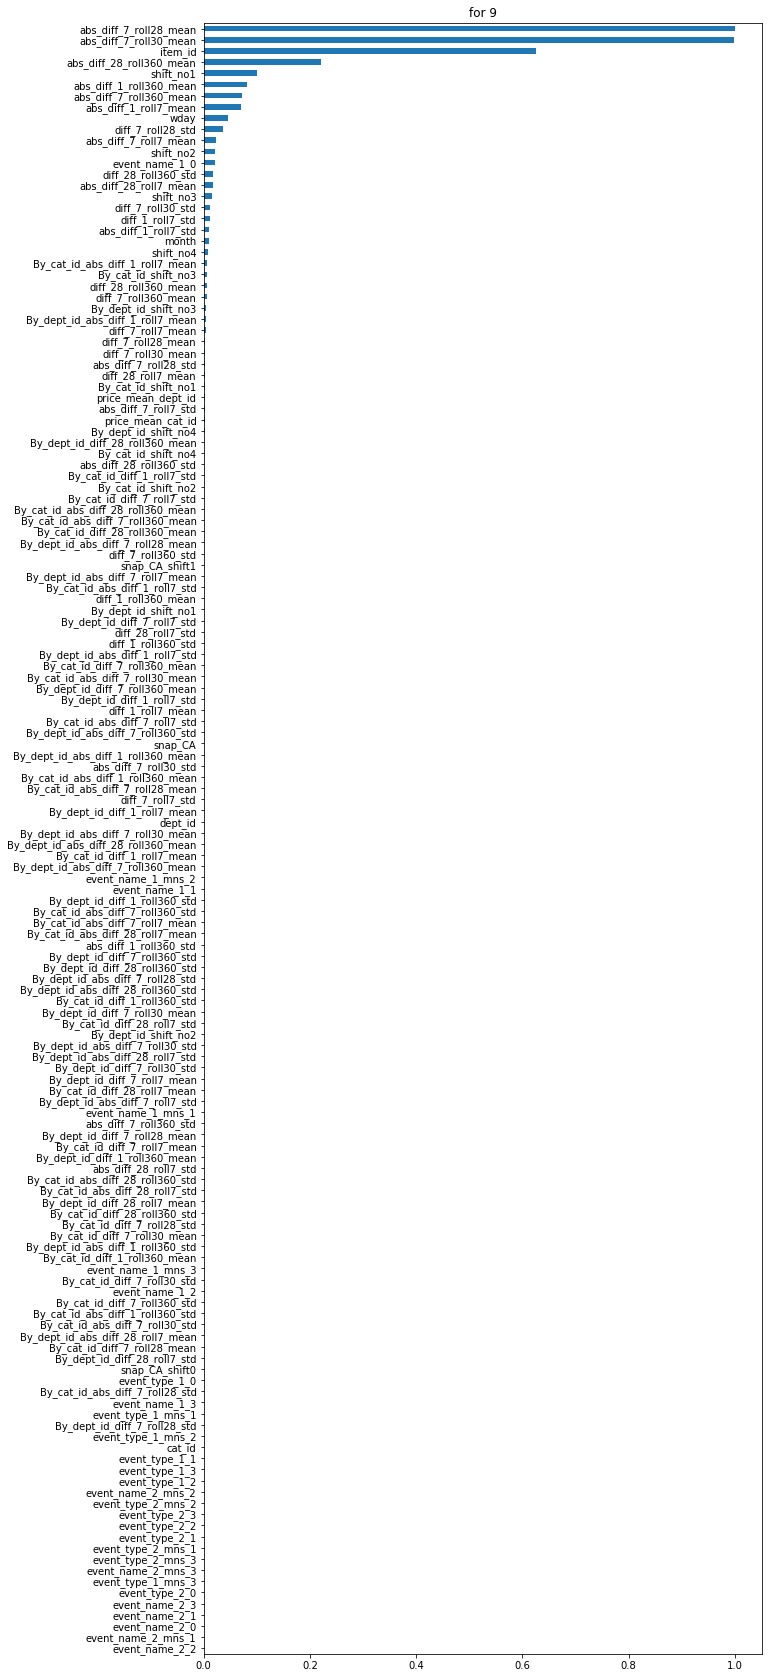

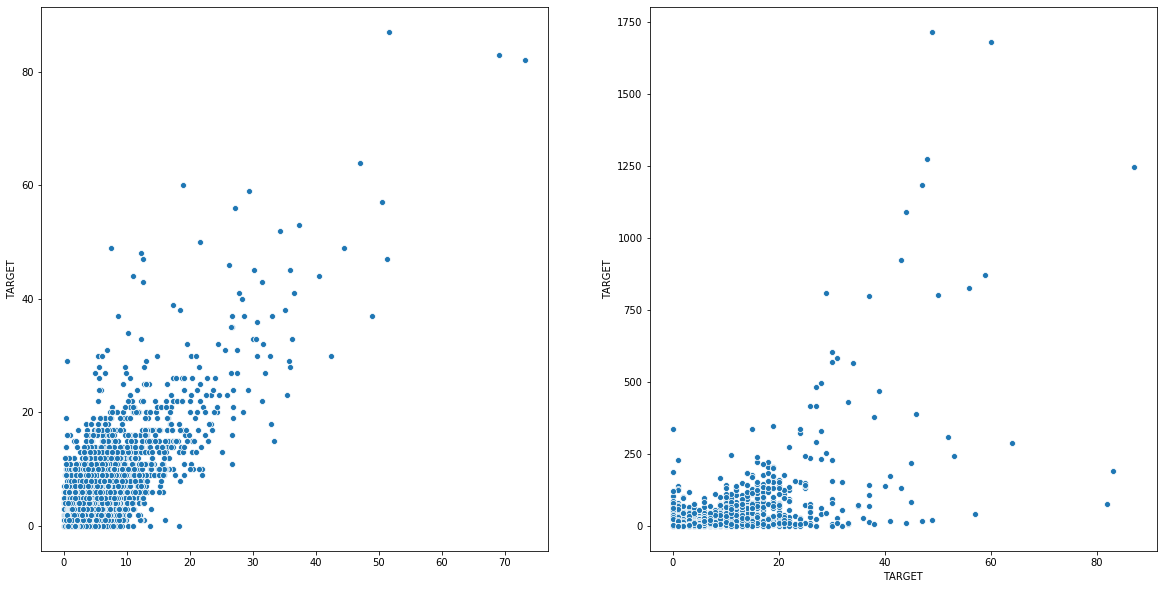


        #########################################
           ##############  11  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.088	valid_1's rmse: 1.93168
[1000]	training's rmse: 2.01888	valid_1's rmse: 1.91483
Early stopping, best iteration is:
[982]	training's rmse: 2.02081	valid_1's rmse: 1.91447


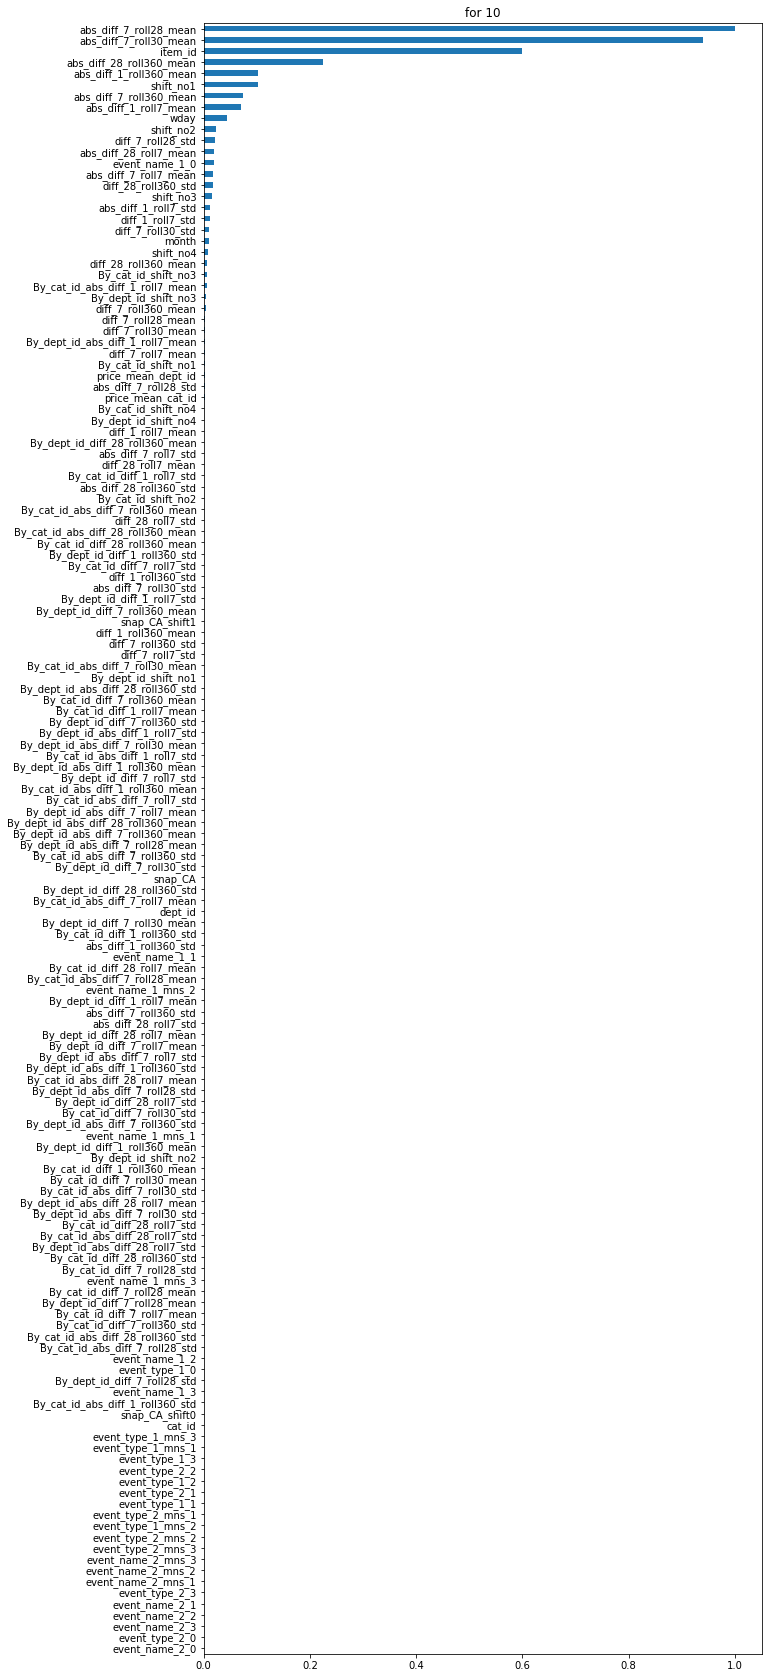

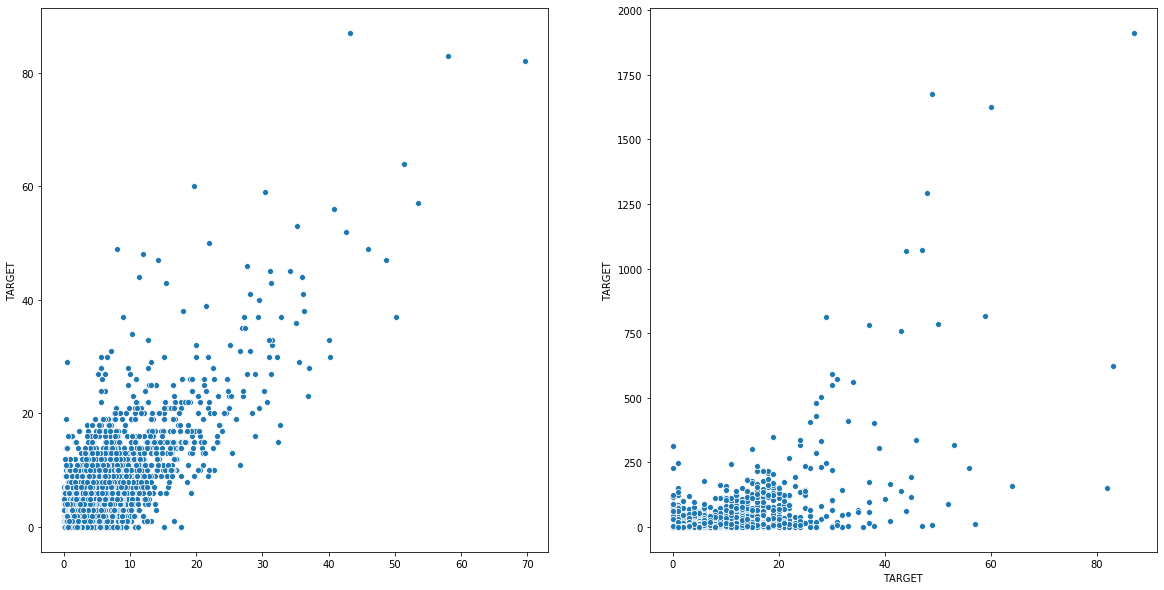


        #########################################
           ##############  12  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.0909	valid_1's rmse: 1.9347
Early stopping, best iteration is:
[824]	training's rmse: 2.03641	valid_1's rmse: 1.91781


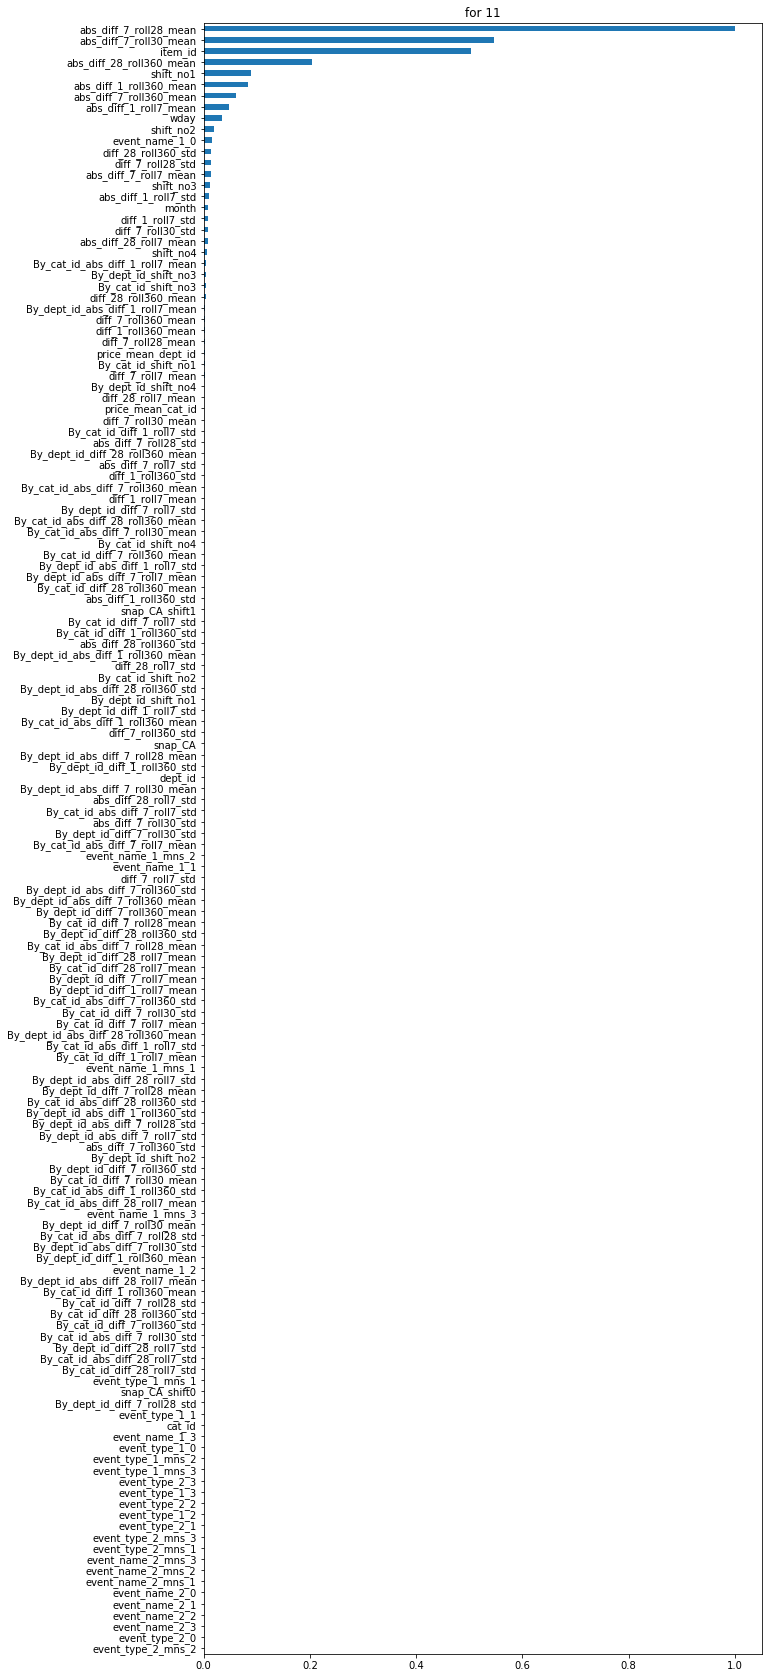

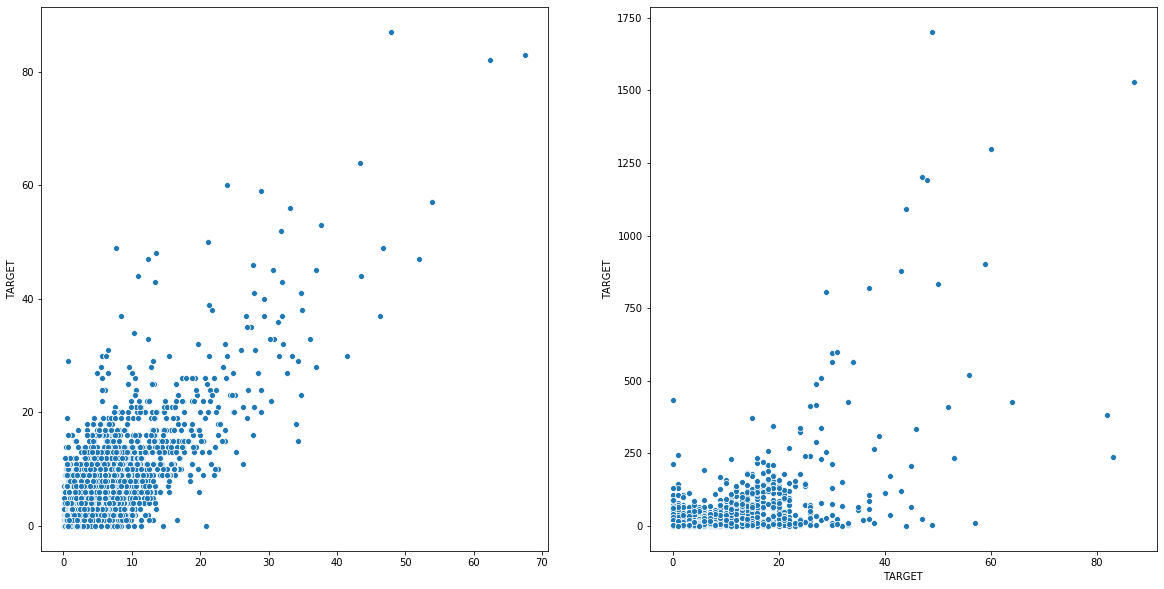


        #########################################
           ##############  13  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09508	valid_1's rmse: 1.92912
Early stopping, best iteration is:
[786]	training's rmse: 2.04672	valid_1's rmse: 1.91651


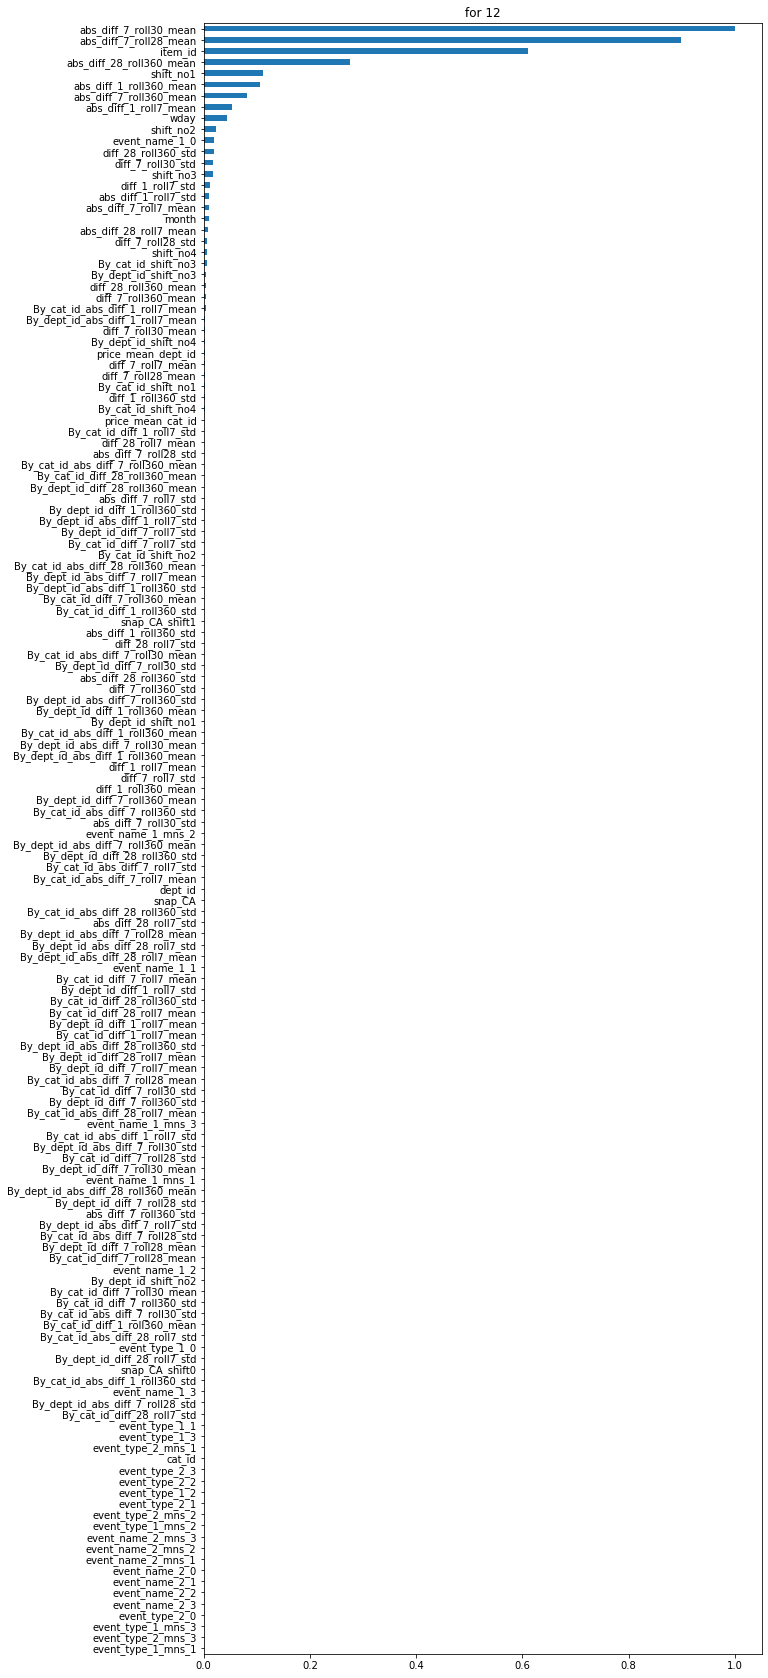

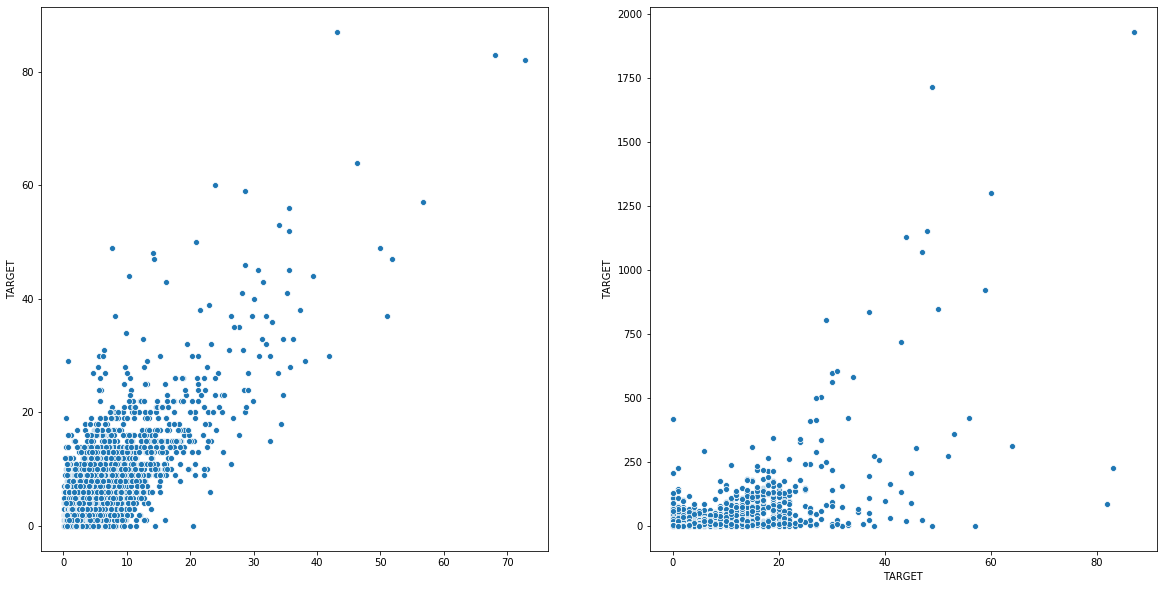


        #########################################
           ##############  14  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09653	valid_1's rmse: 1.929
Early stopping, best iteration is:
[815]	training's rmse: 2.04603	valid_1's rmse: 1.91571


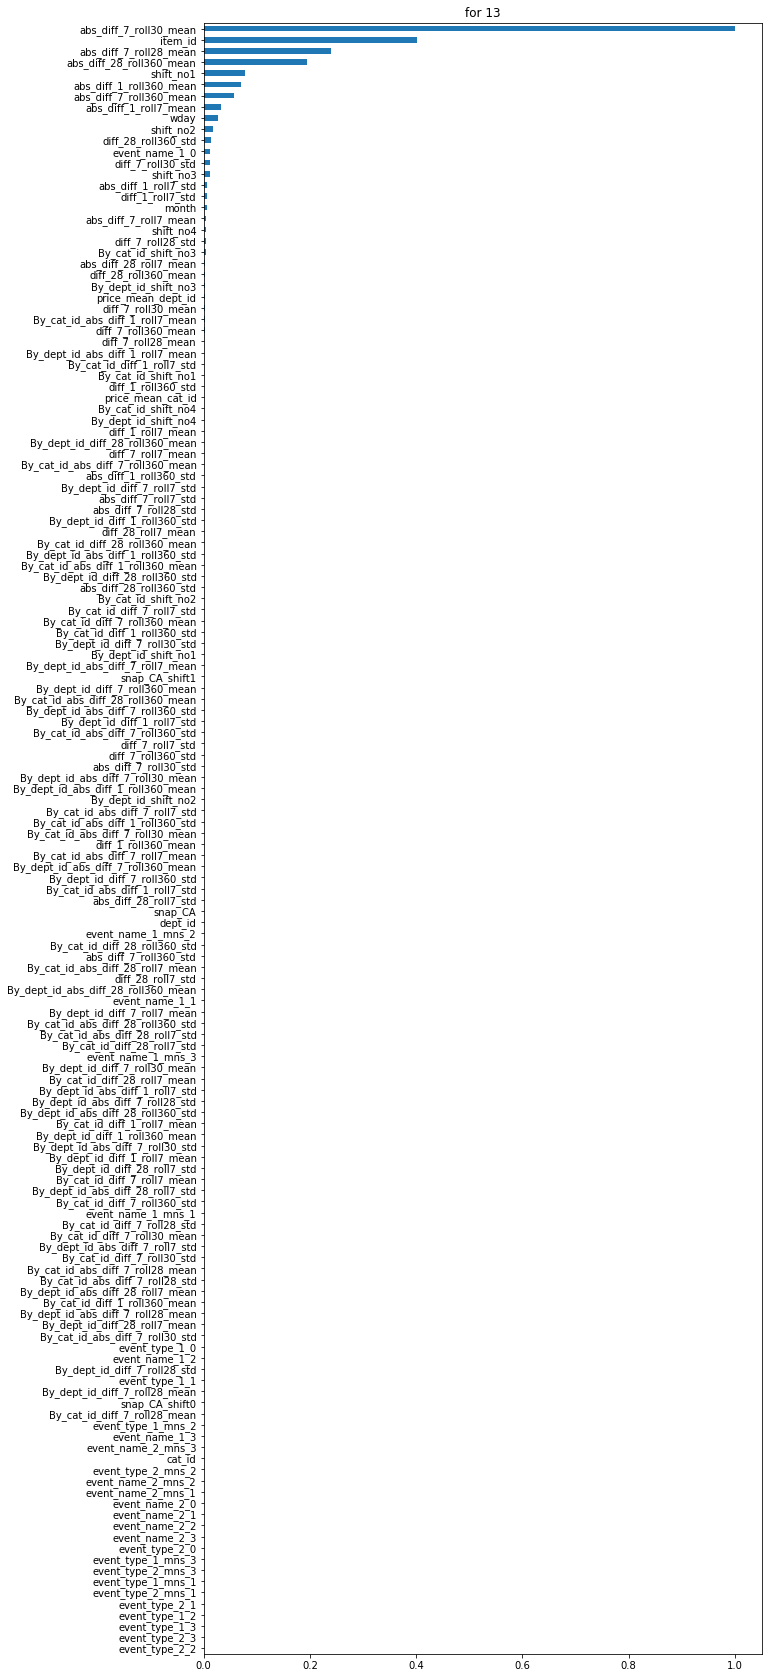

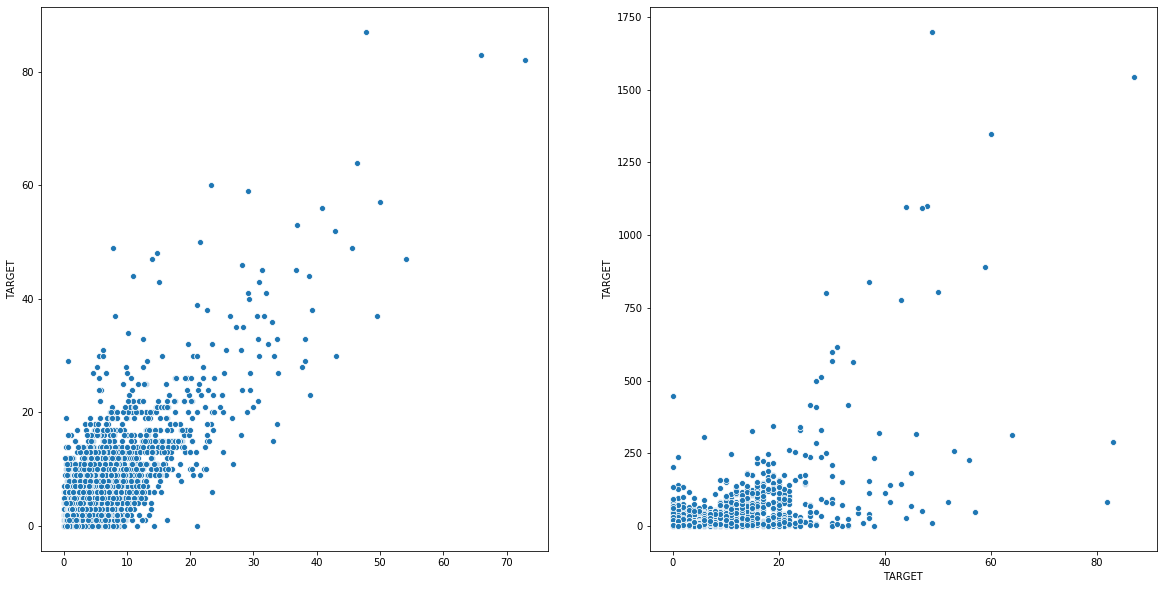


        #########################################
           ##############  15  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09097	valid_1's rmse: 1.92792
Early stopping, best iteration is:
[853]	training's rmse: 2.03344	valid_1's rmse: 1.90887


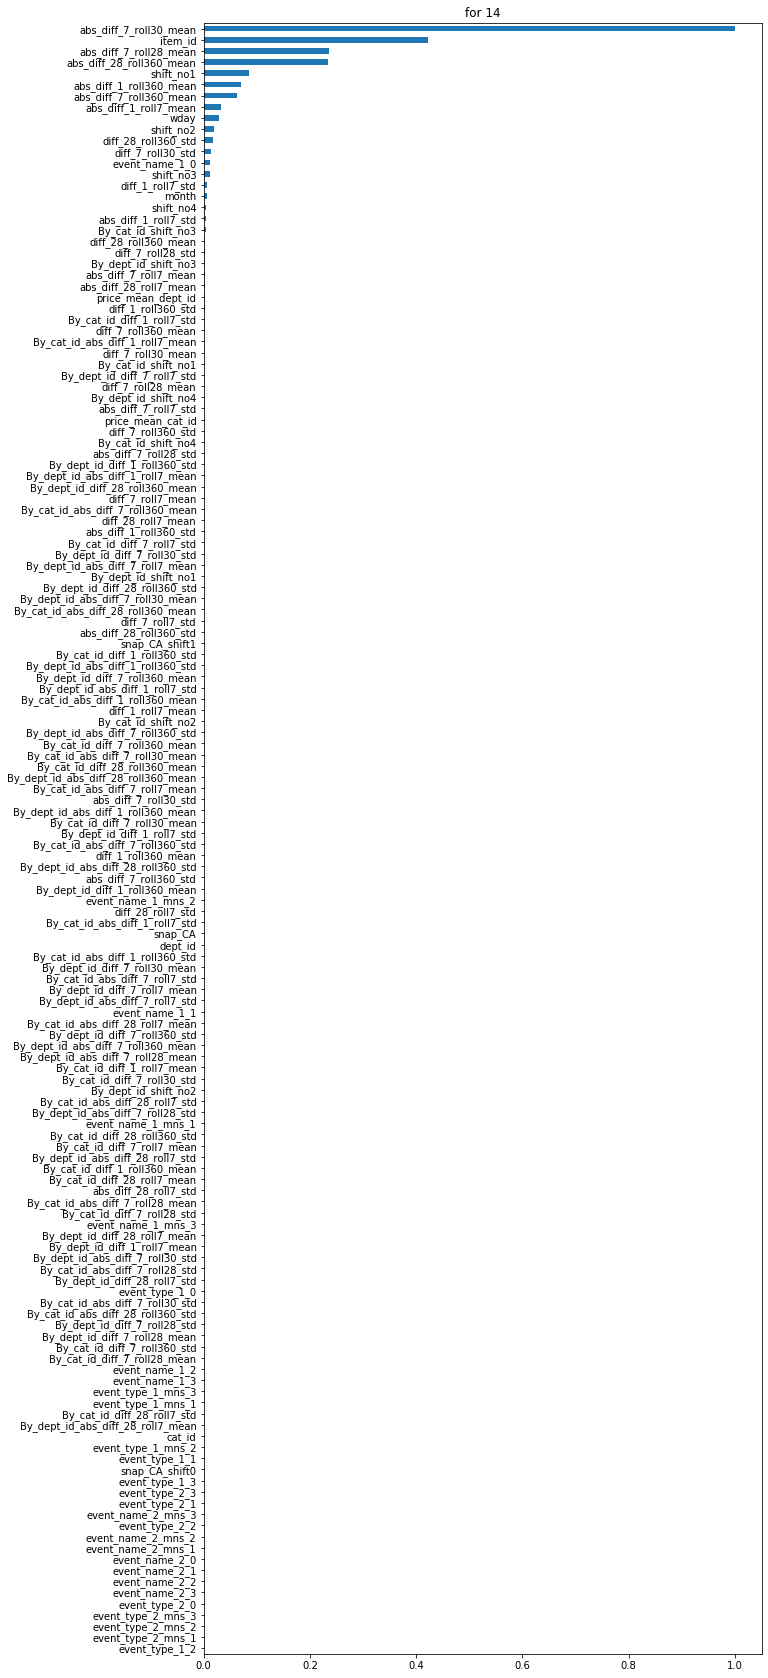

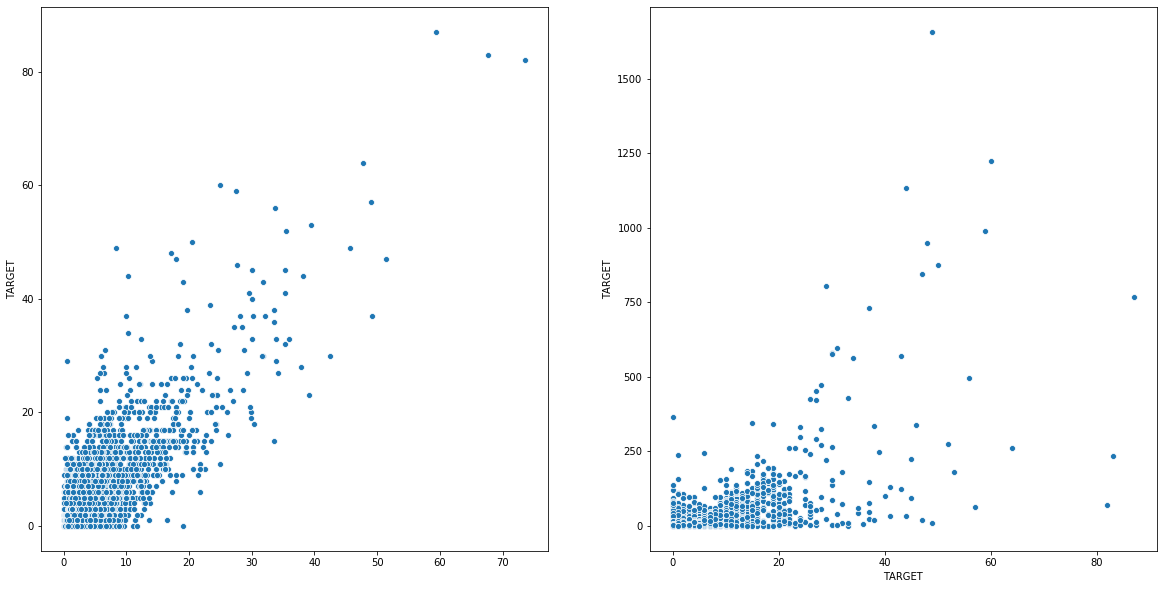


        #########################################
           ##############  16  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09279	valid_1's rmse: 1.93323
[1000]	training's rmse: 2.01672	valid_1's rmse: 1.91534
Early stopping, best iteration is:
[928]	training's rmse: 2.0248	valid_1's rmse: 1.91461


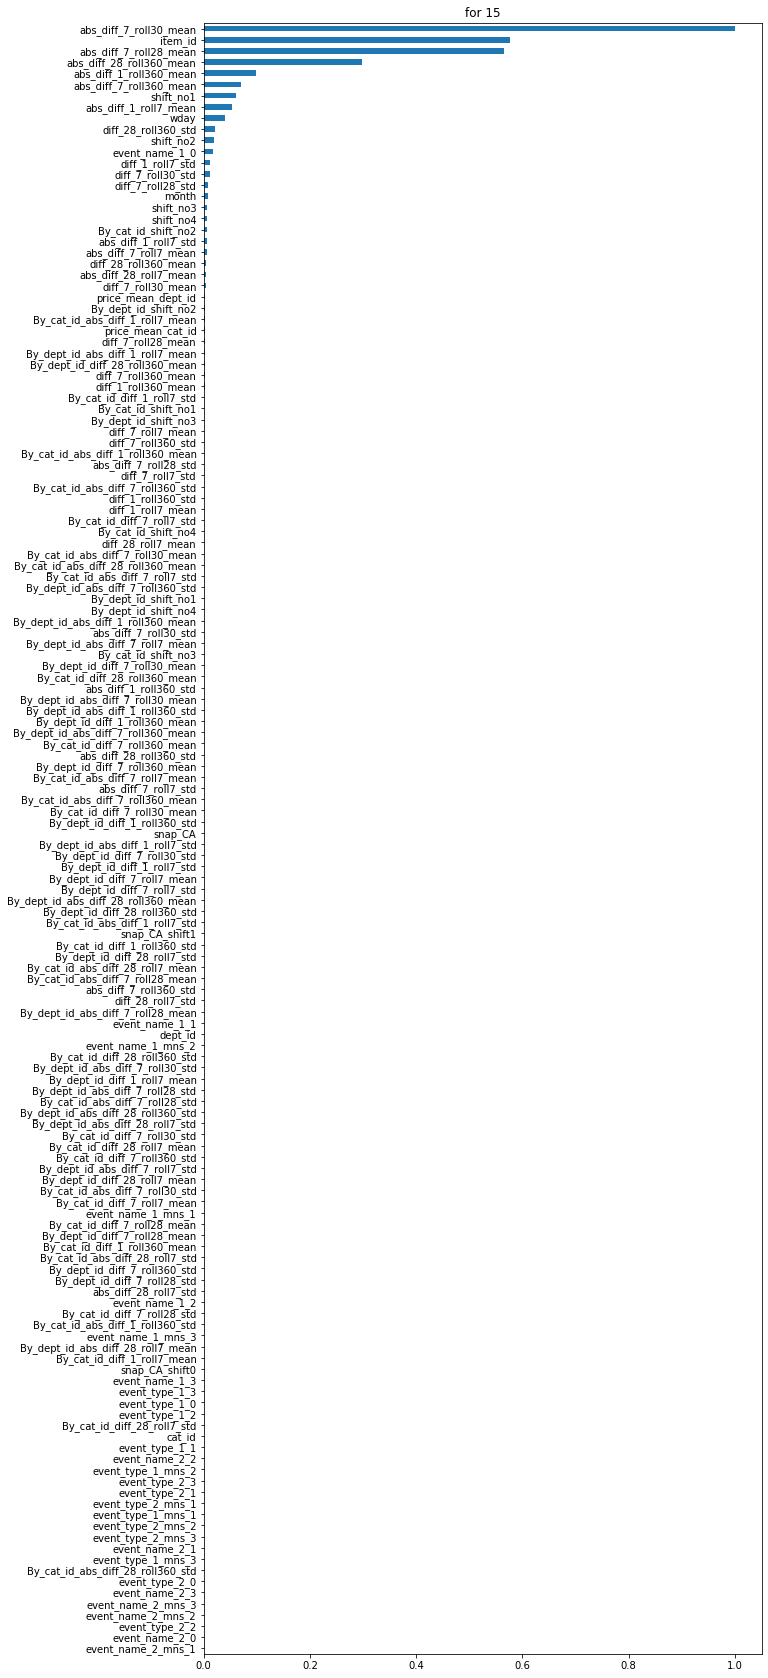

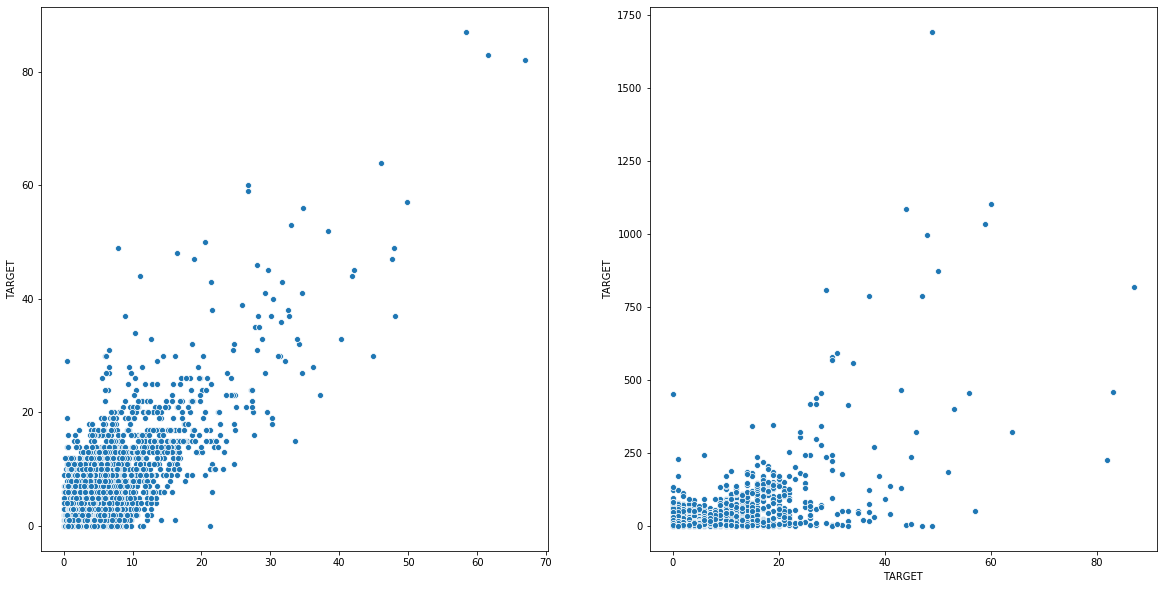


        #########################################
           ##############  17  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09291	valid_1's rmse: 1.95089
[1000]	training's rmse: 2.0189	valid_1's rmse: 1.9308
Early stopping, best iteration is:
[931]	training's rmse: 2.0265	valid_1's rmse: 1.92985


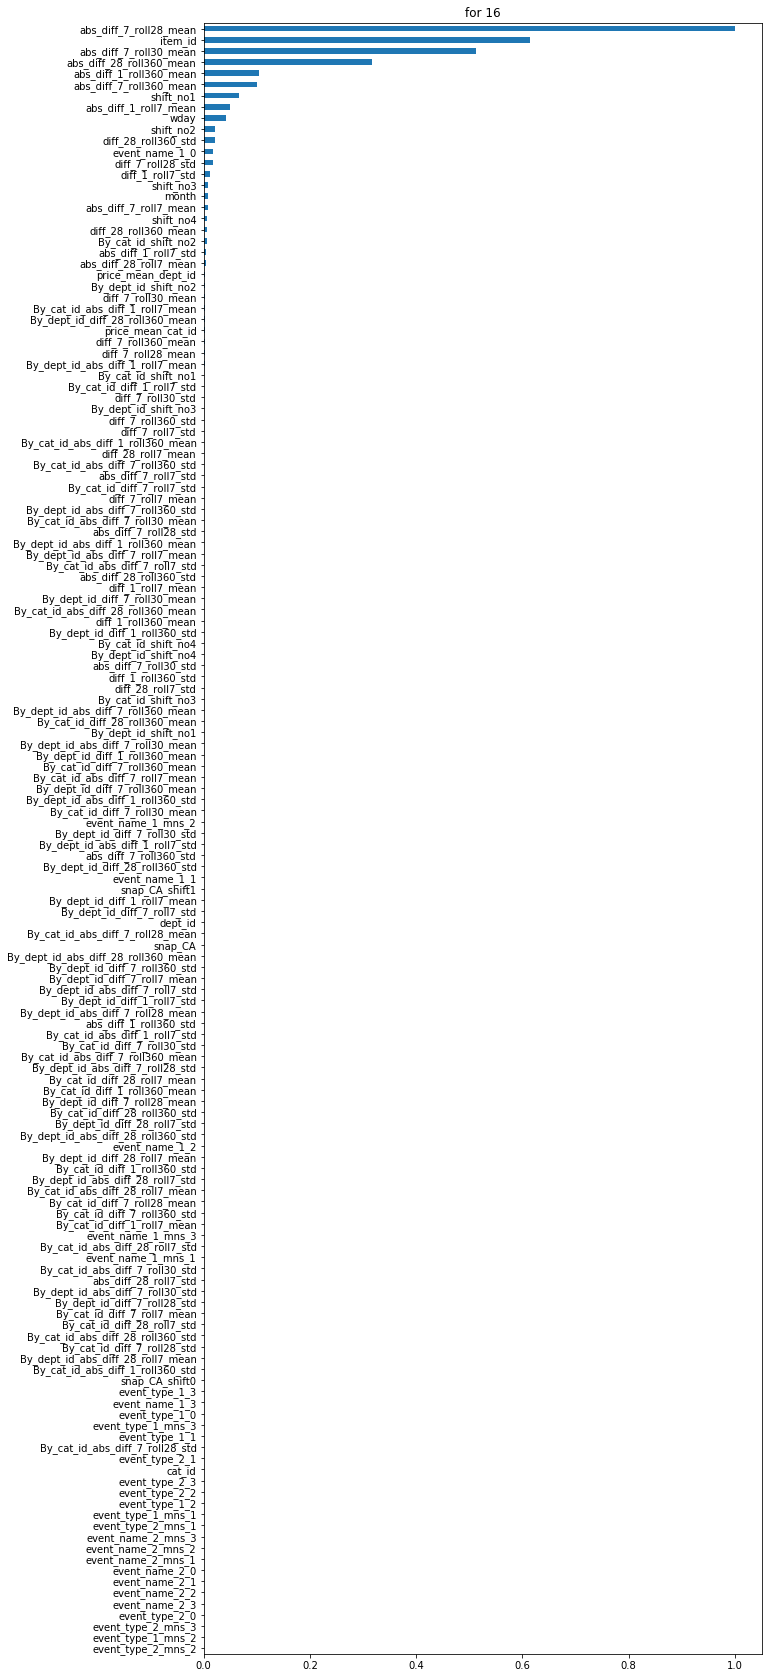

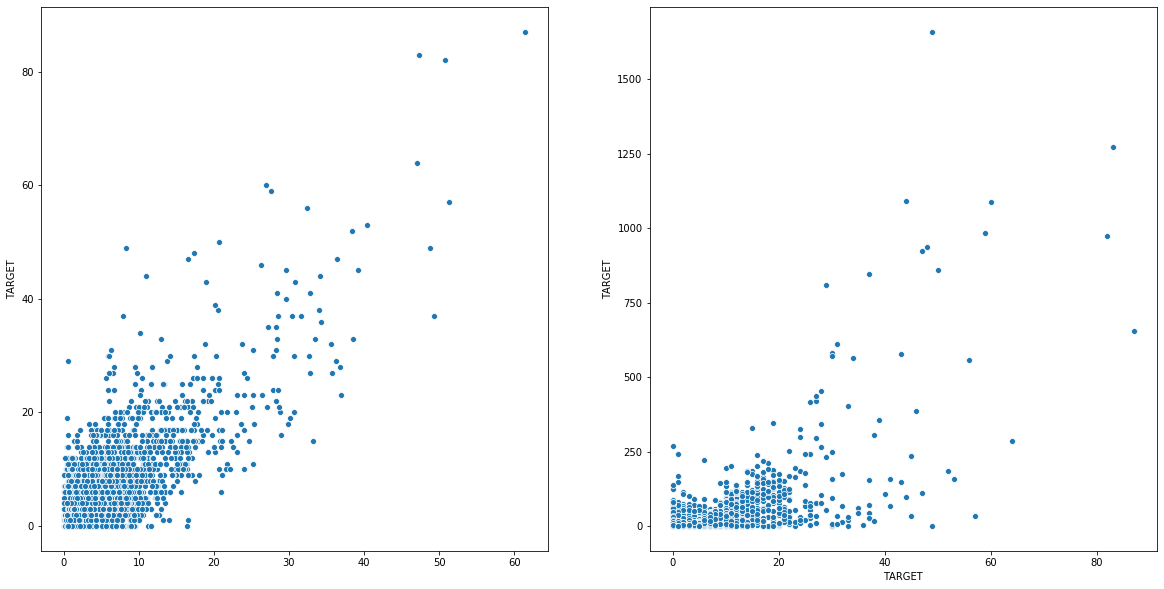


        #########################################
           ##############  18  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09304	valid_1's rmse: 1.94464
Early stopping, best iteration is:
[898]	training's rmse: 2.03059	valid_1's rmse: 1.92199


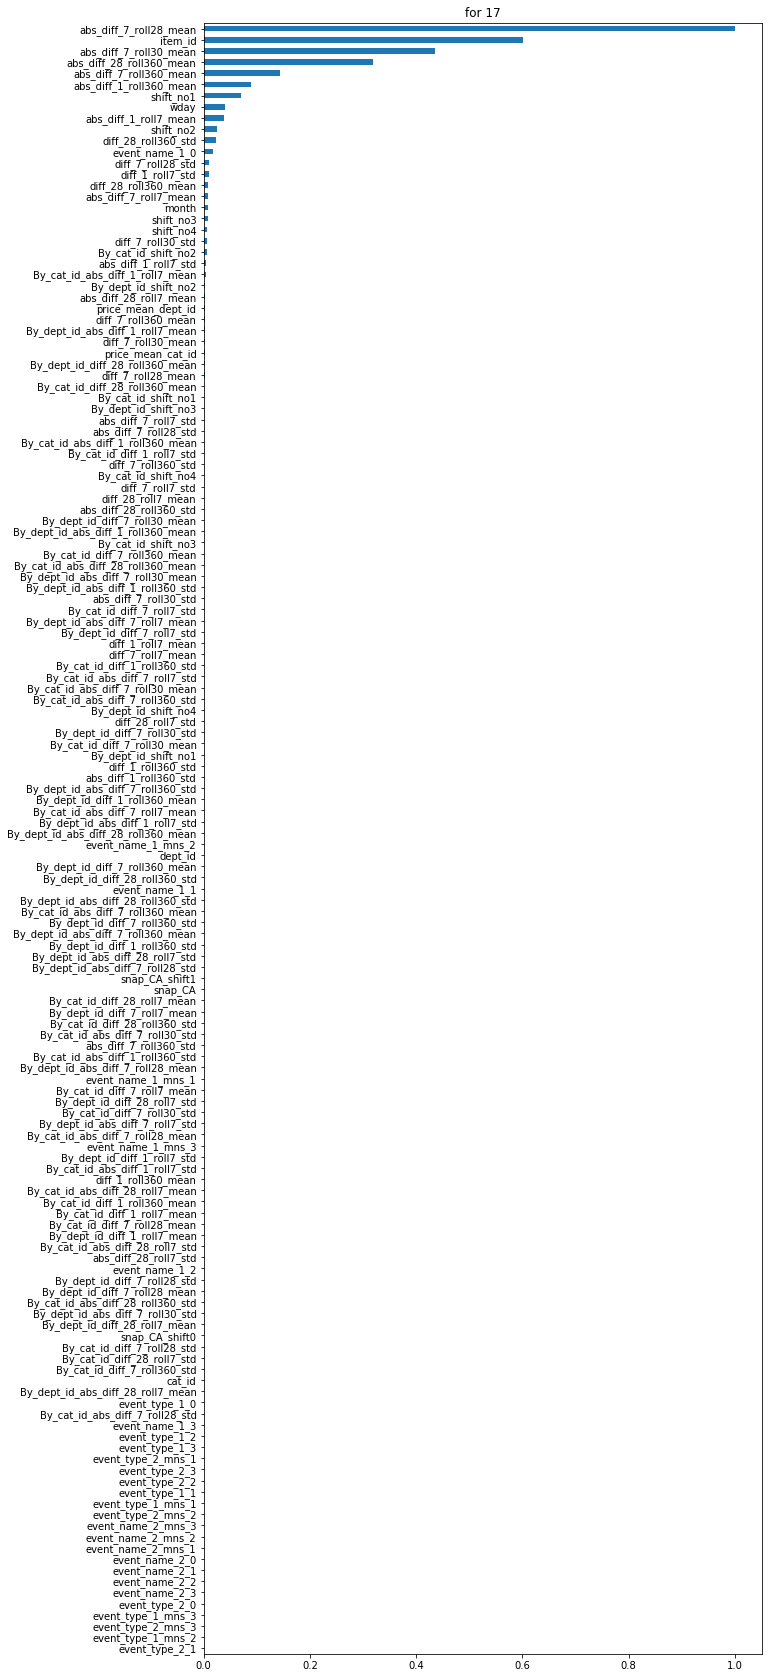

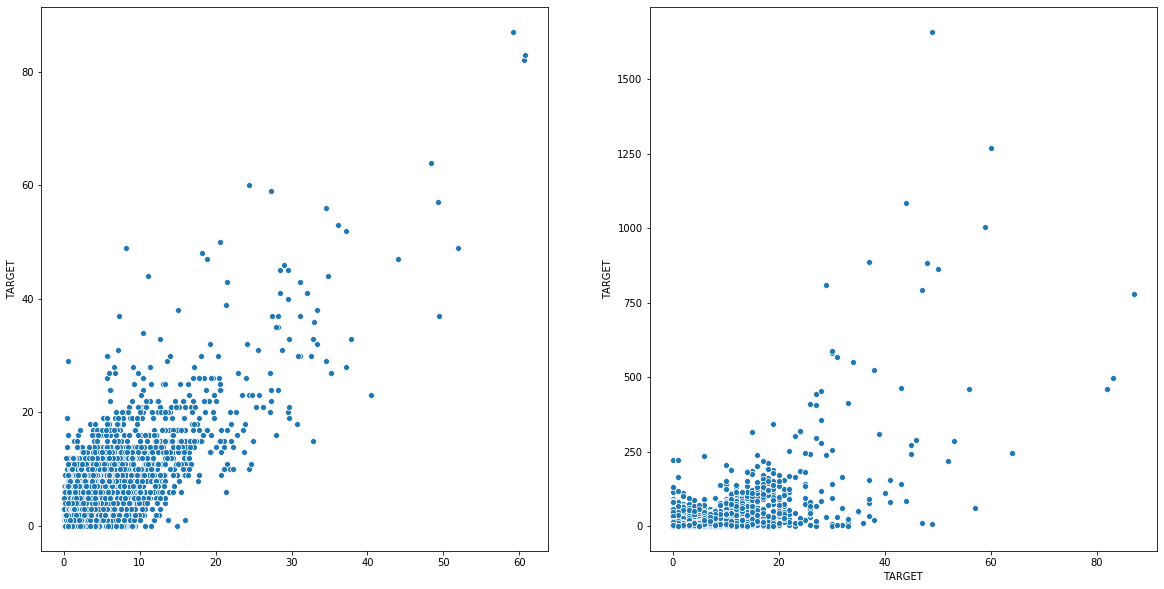


        #########################################
           ##############  19  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09347	valid_1's rmse: 1.95675
[1000]	training's rmse: 2.02116	valid_1's rmse: 1.93643
Early stopping, best iteration is:
[922]	training's rmse: 2.02929	valid_1's rmse: 1.93609


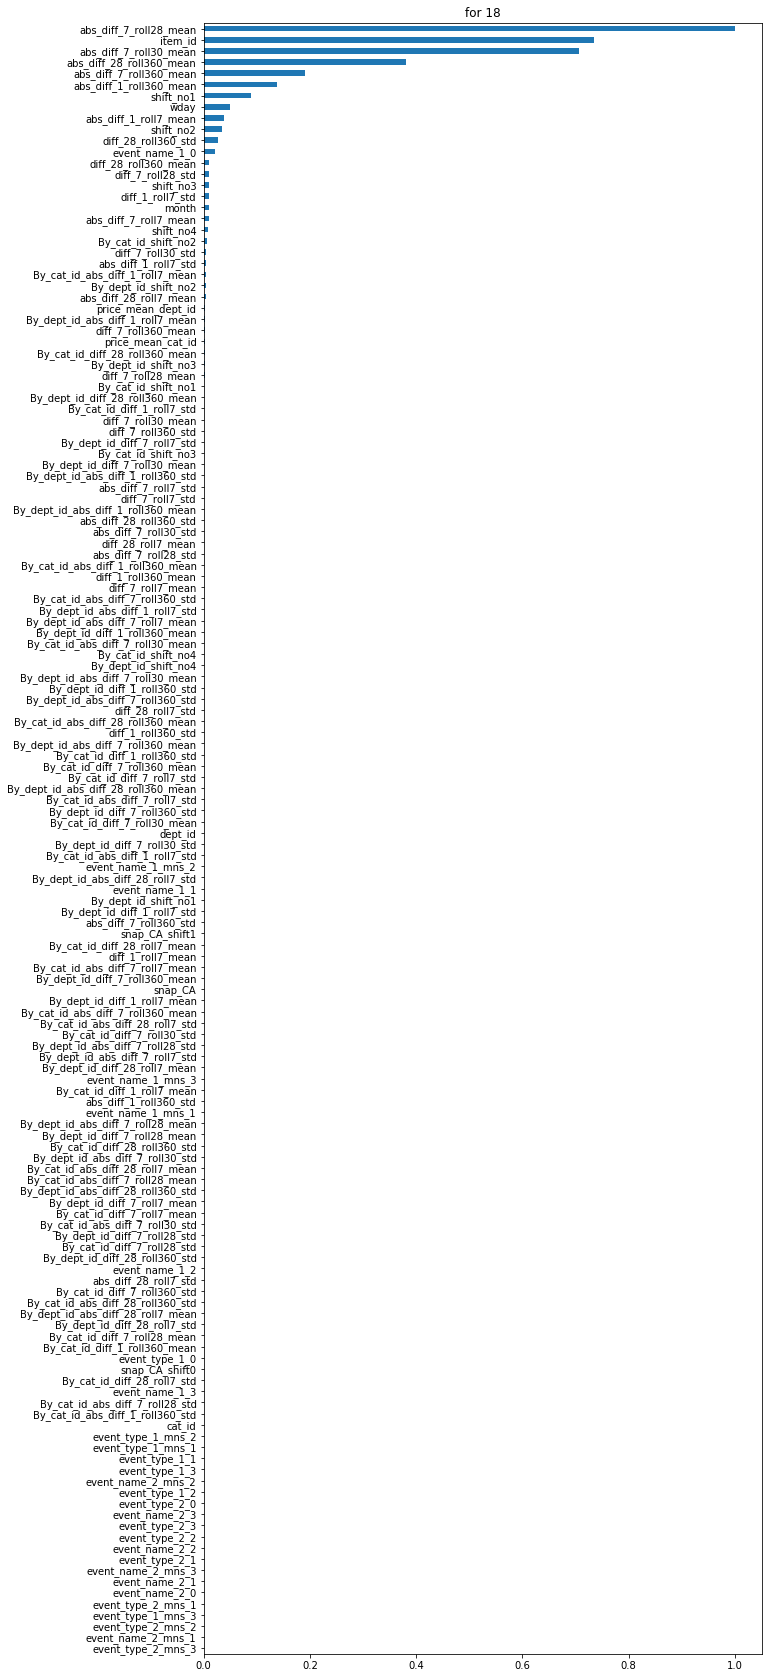

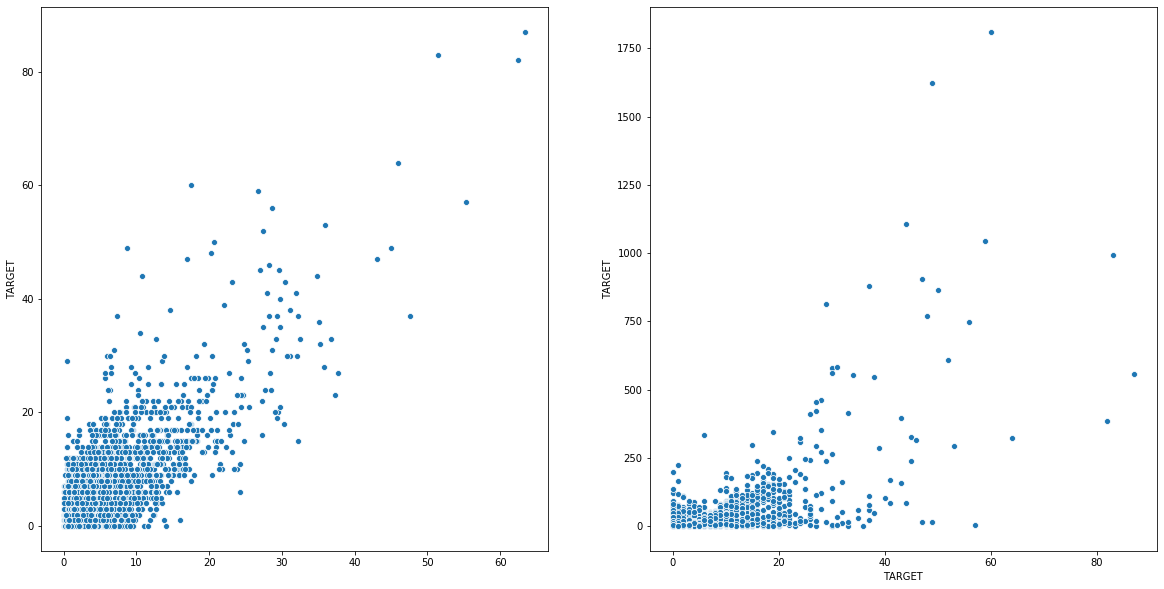


        #########################################
           ##############  20  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.0956	valid_1's rmse: 1.95514
Early stopping, best iteration is:
[785]	training's rmse: 2.04519	valid_1's rmse: 1.93743


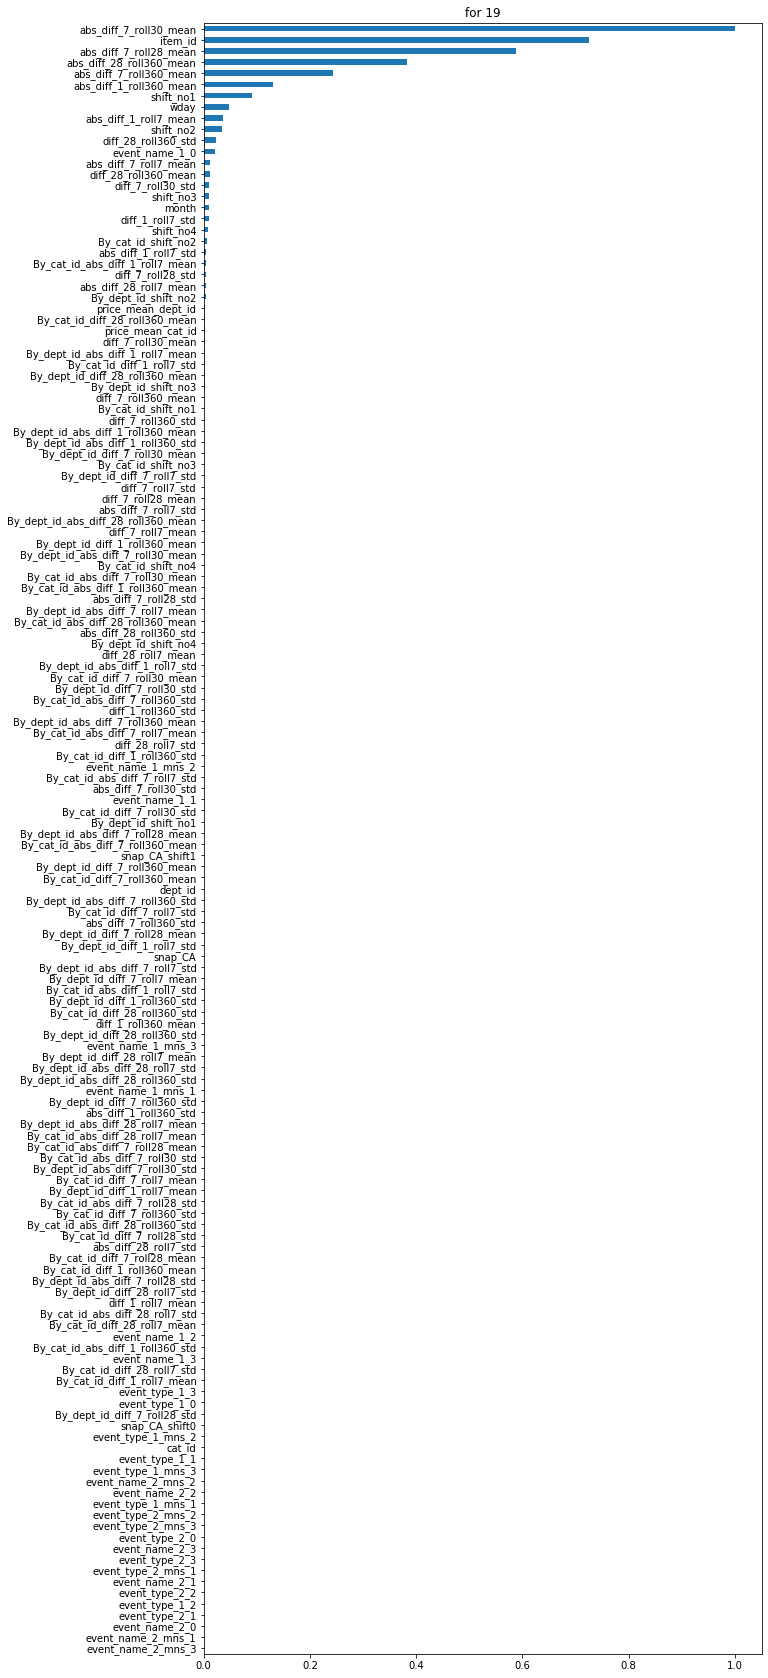

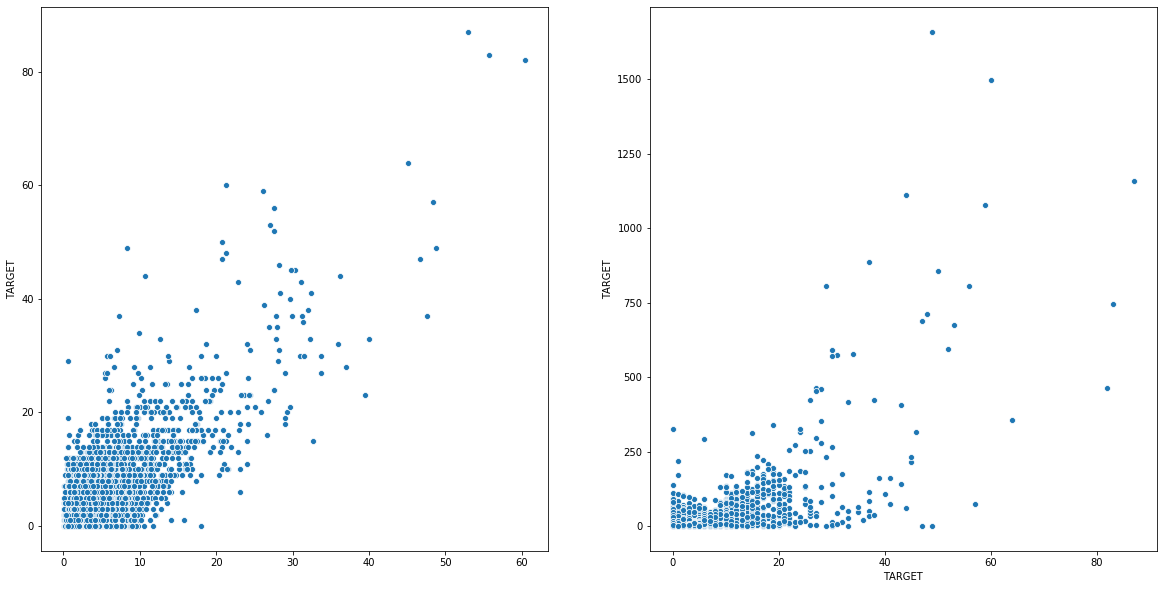


        #########################################
           ##############  21  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09608	valid_1's rmse: 1.96282
[1000]	training's rmse: 2.02537	valid_1's rmse: 1.94275
Early stopping, best iteration is:
[924]	training's rmse: 2.03308	valid_1's rmse: 1.94215


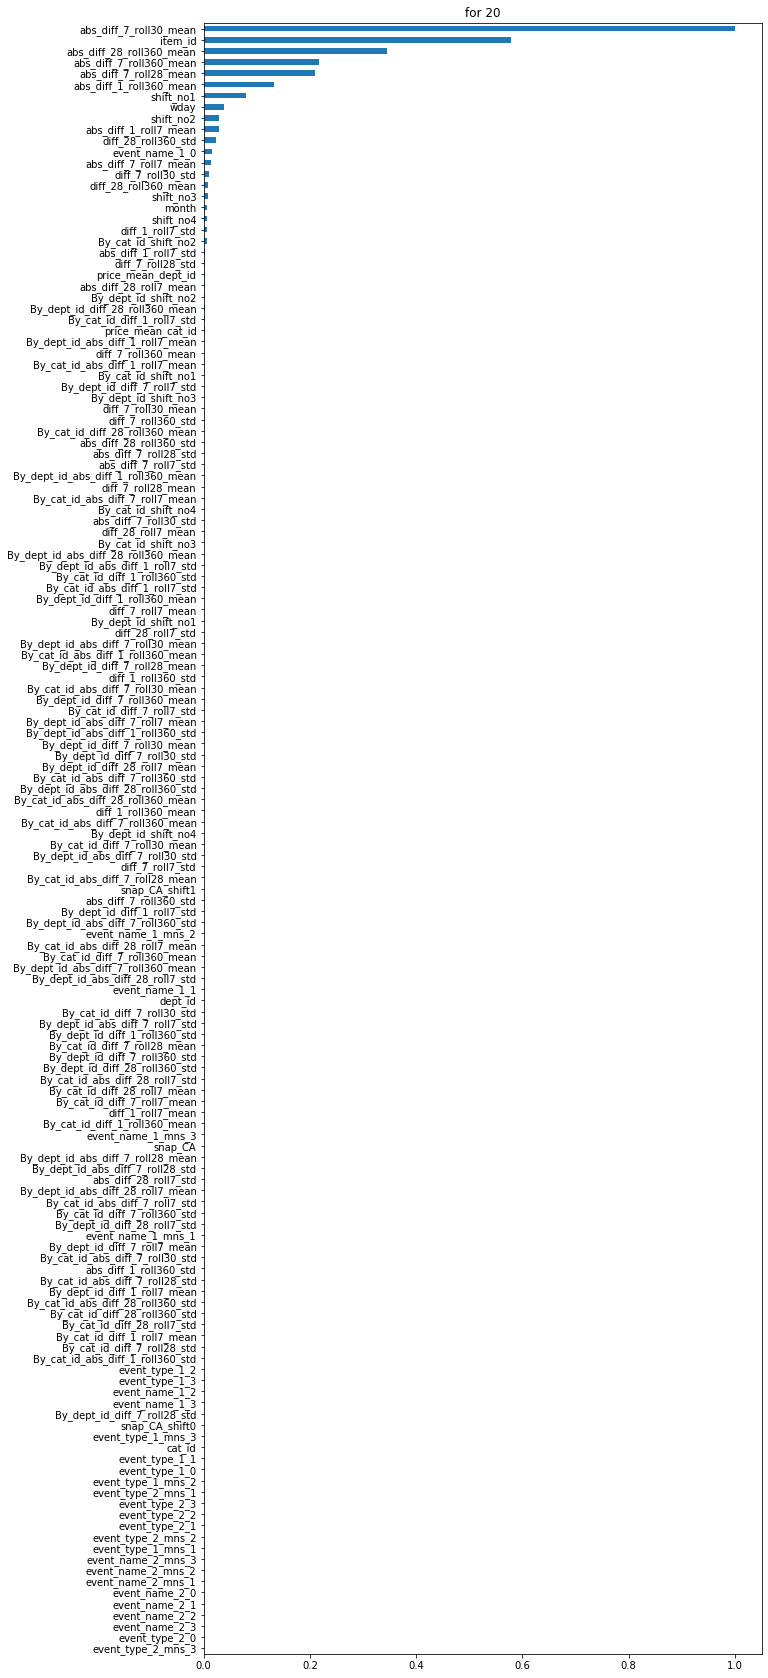

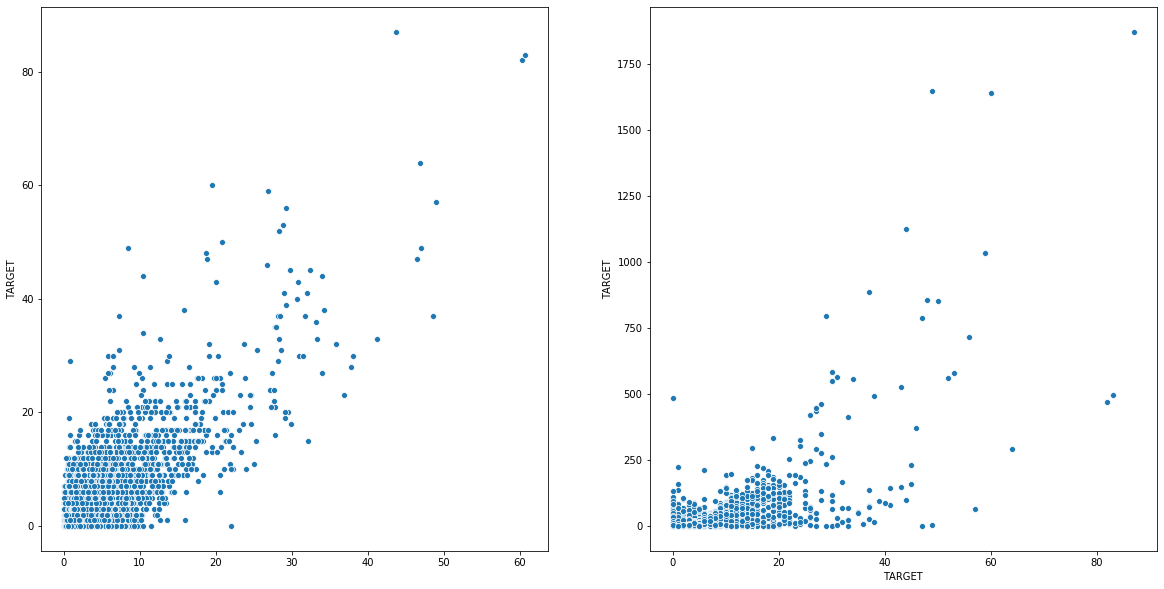


        #########################################
           ##############  22  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.08543	valid_1's rmse: 1.9606
[1000]	training's rmse: 2.01164	valid_1's rmse: 1.94089
Early stopping, best iteration is:
[998]	training's rmse: 2.01199	valid_1's rmse: 1.94071


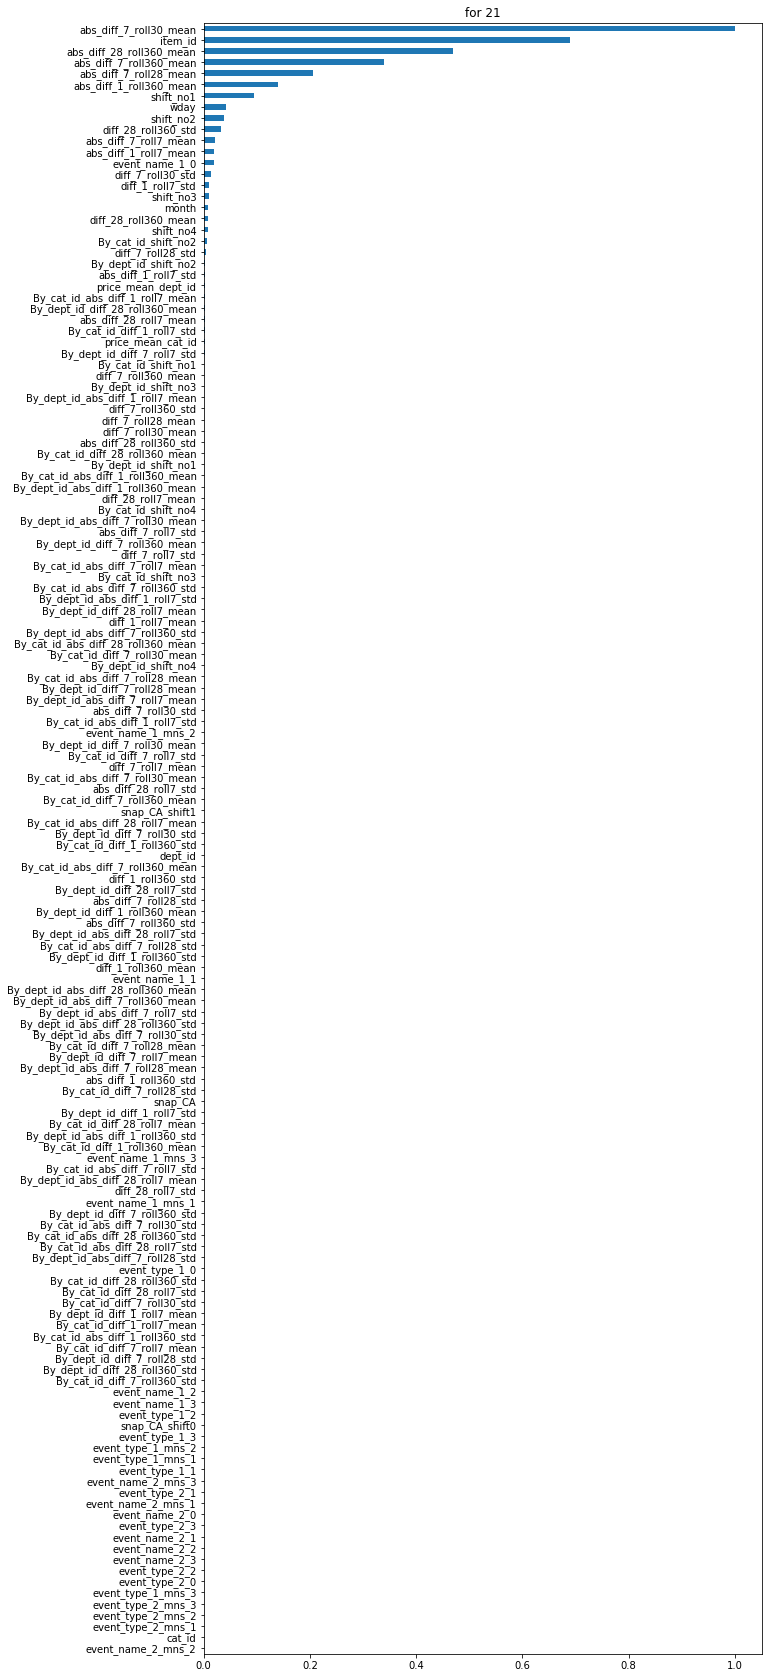

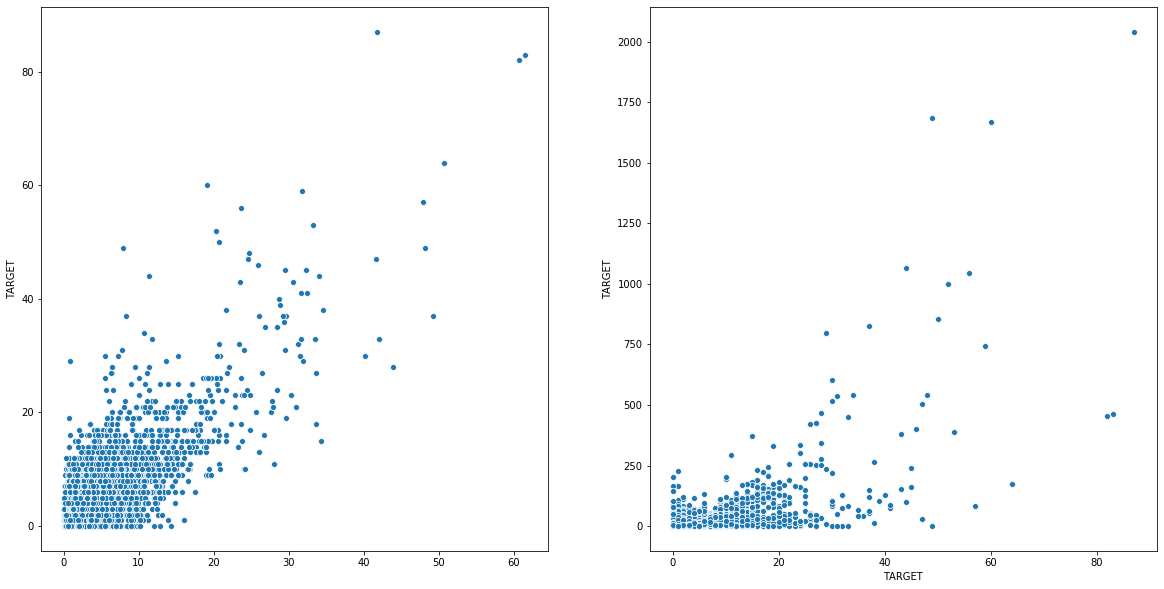


        #########################################
           ##############  23  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.08633	valid_1's rmse: 1.96258
[1000]	training's rmse: 2.01374	valid_1's rmse: 1.93764
Early stopping, best iteration is:
[1009]	training's rmse: 2.01248	valid_1's rmse: 1.93753


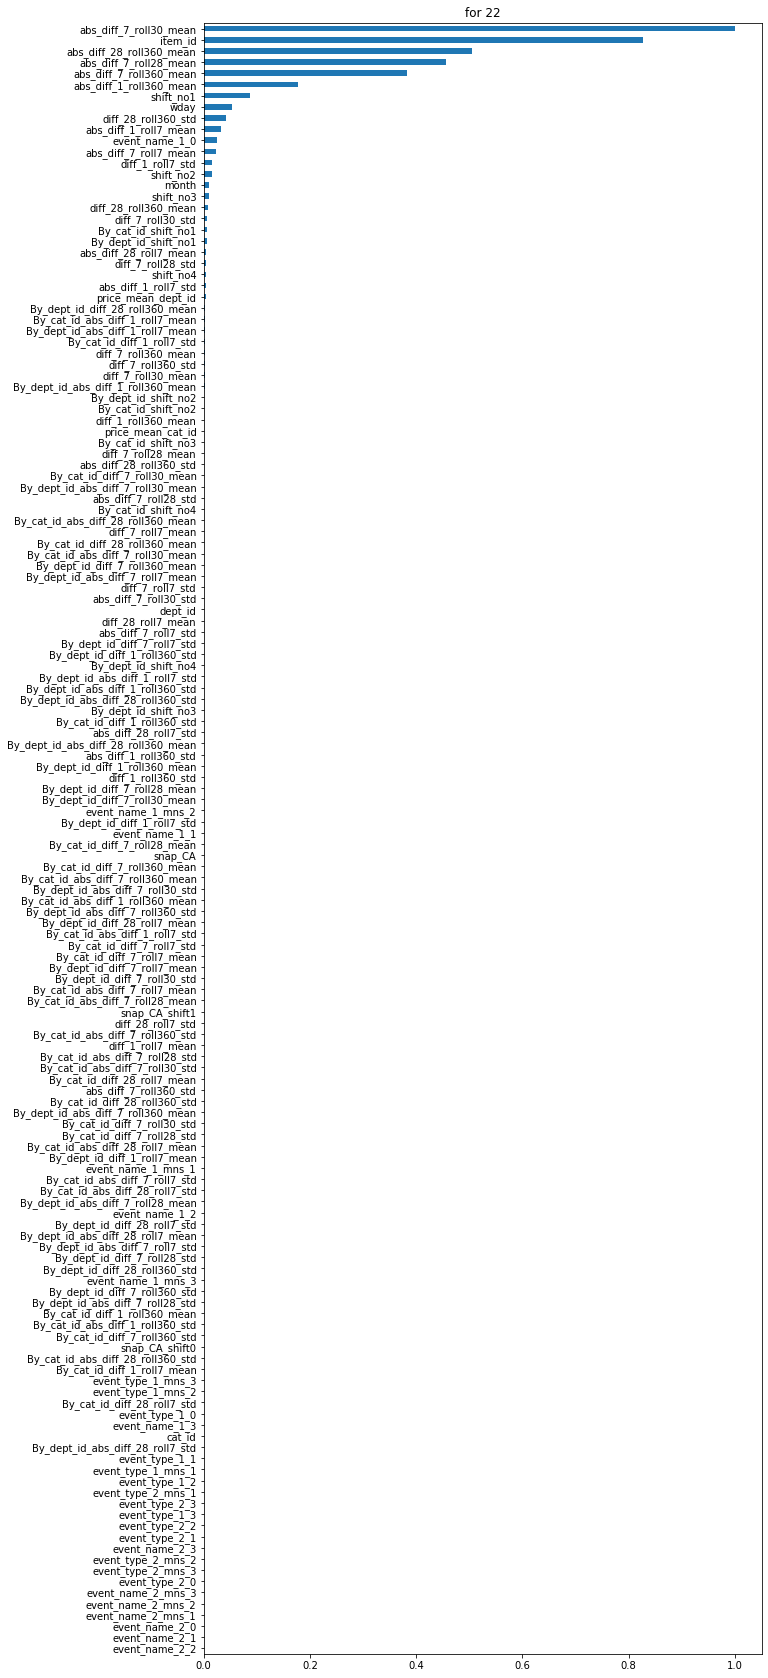

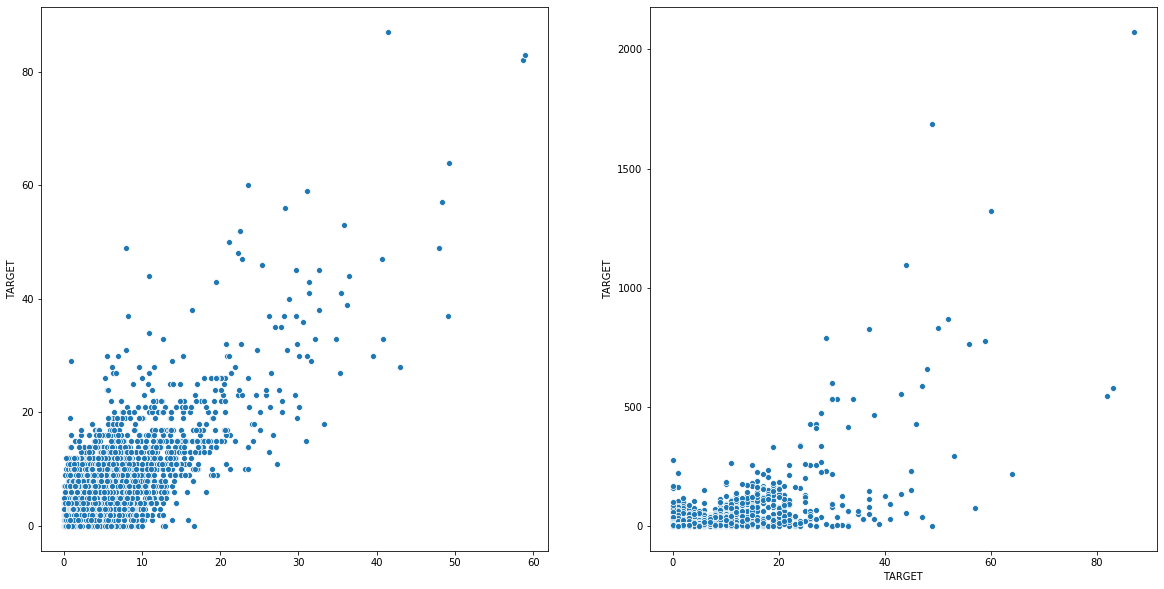


        #########################################
           ##############  24  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09165	valid_1's rmse: 1.96942
[1000]	training's rmse: 2.01857	valid_1's rmse: 1.94383
Early stopping, best iteration is:
[1015]	training's rmse: 2.01666	valid_1's rmse: 1.94336


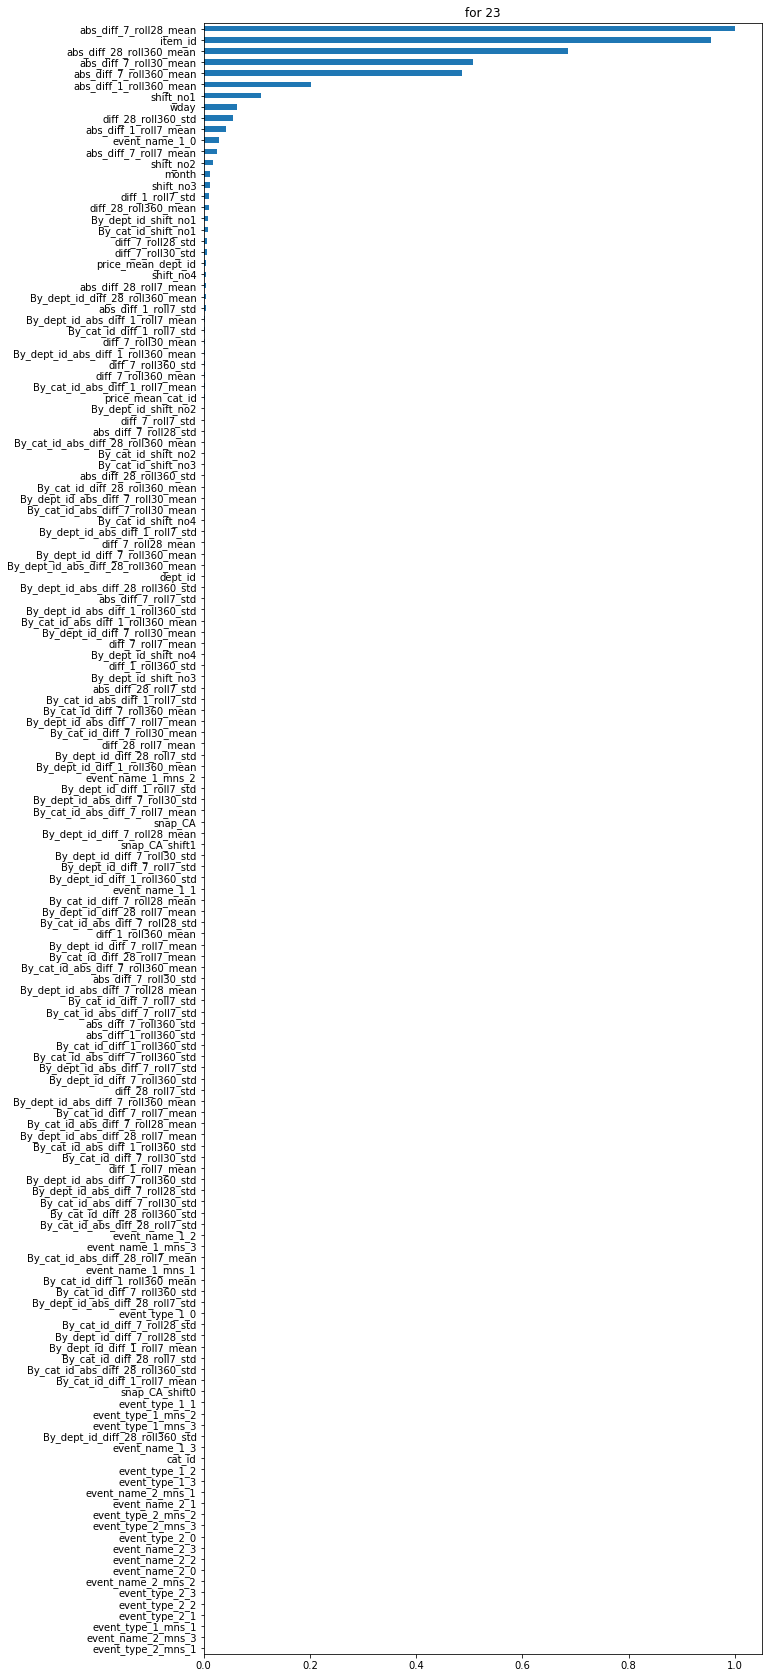

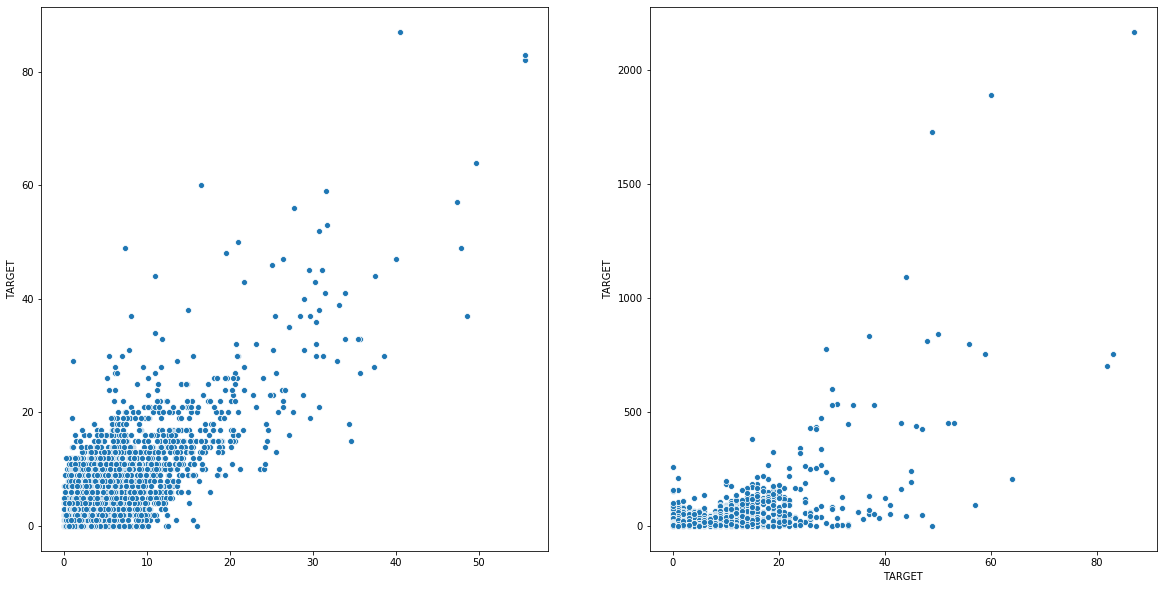


        #########################################
           ##############  25  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.08876	valid_1's rmse: 1.97986
[1000]	training's rmse: 2.0165	valid_1's rmse: 1.95422
Early stopping, best iteration is:
[1051]	training's rmse: 2.01093	valid_1's rmse: 1.95388


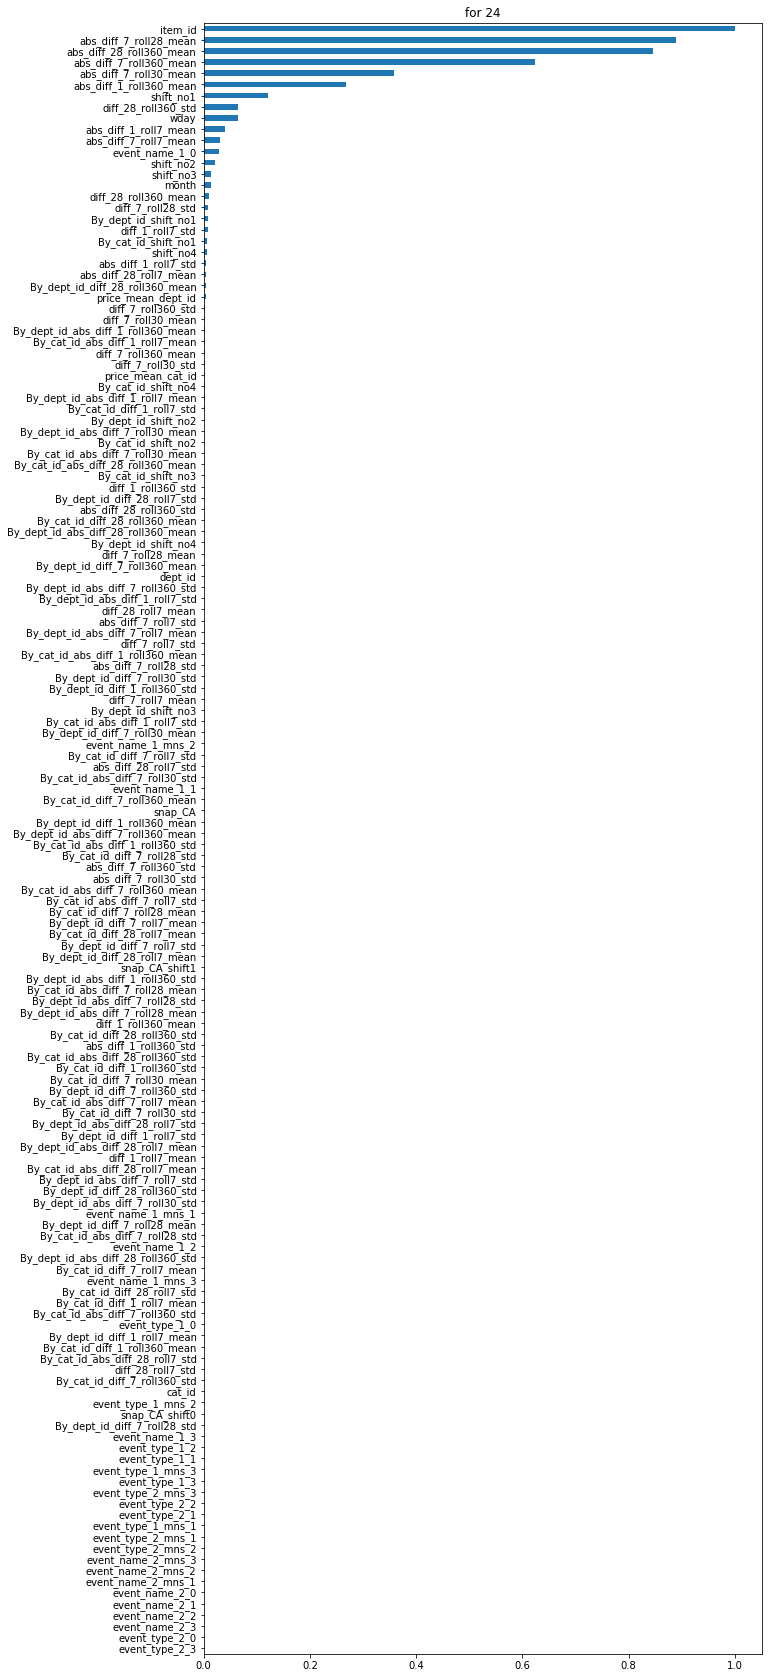

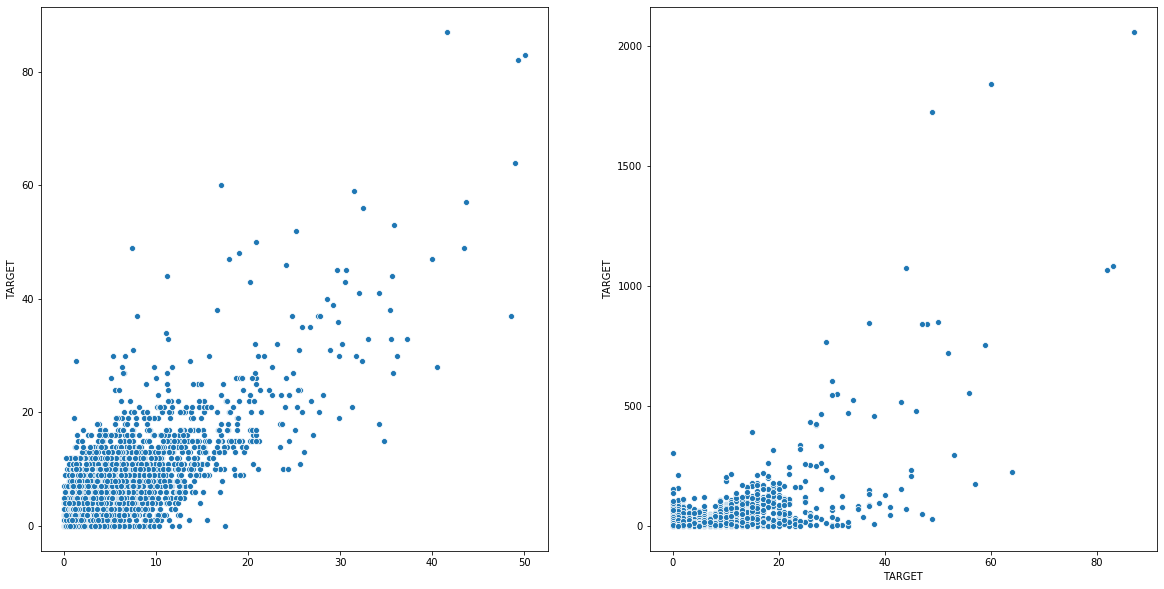


        #########################################
           ##############  26  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.08833	valid_1's rmse: 1.97035
[1000]	training's rmse: 2.01669	valid_1's rmse: 1.94269
Early stopping, best iteration is:
[1231]	training's rmse: 1.99557	valid_1's rmse: 1.94107


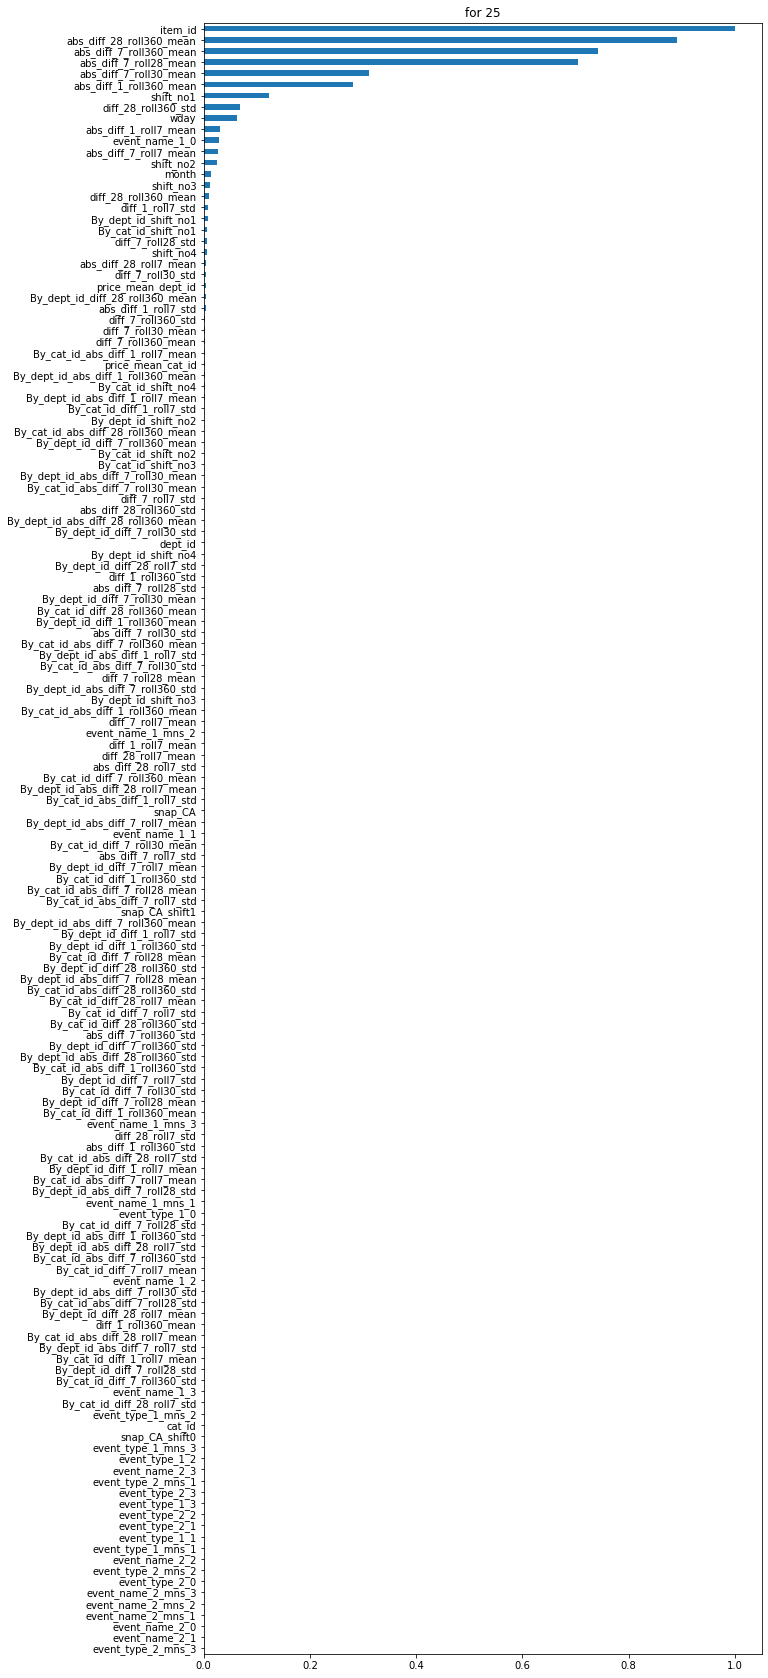

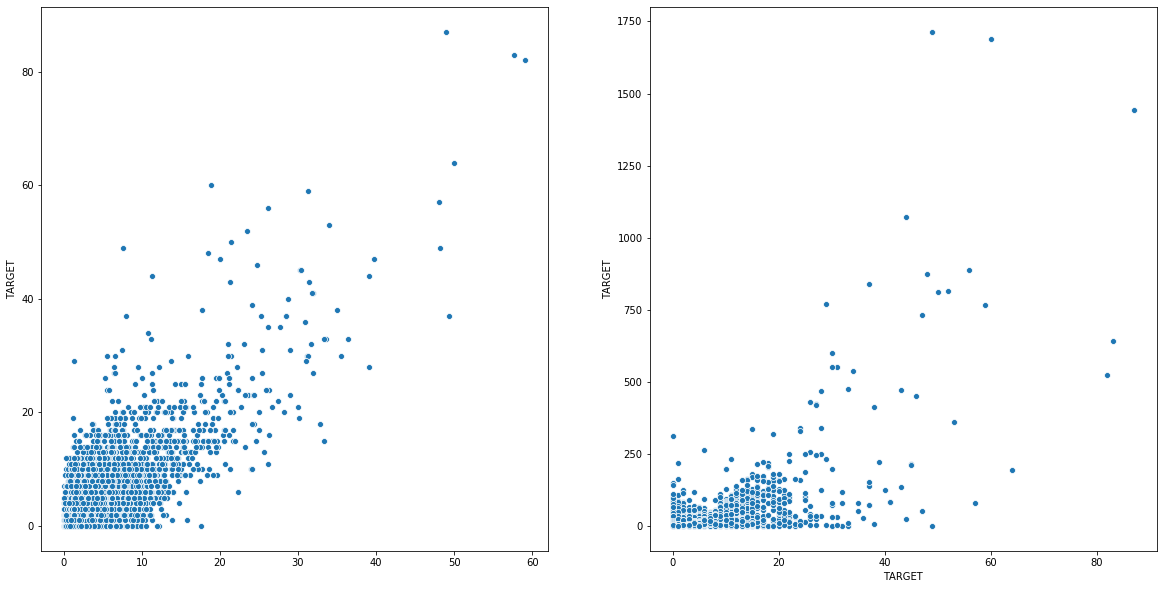


        #########################################
           ##############  27  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.09131	valid_1's rmse: 1.97375
[1000]	training's rmse: 2.01732	valid_1's rmse: 1.94546
Early stopping, best iteration is:
[1385]	training's rmse: 1.97913	valid_1's rmse: 1.94296


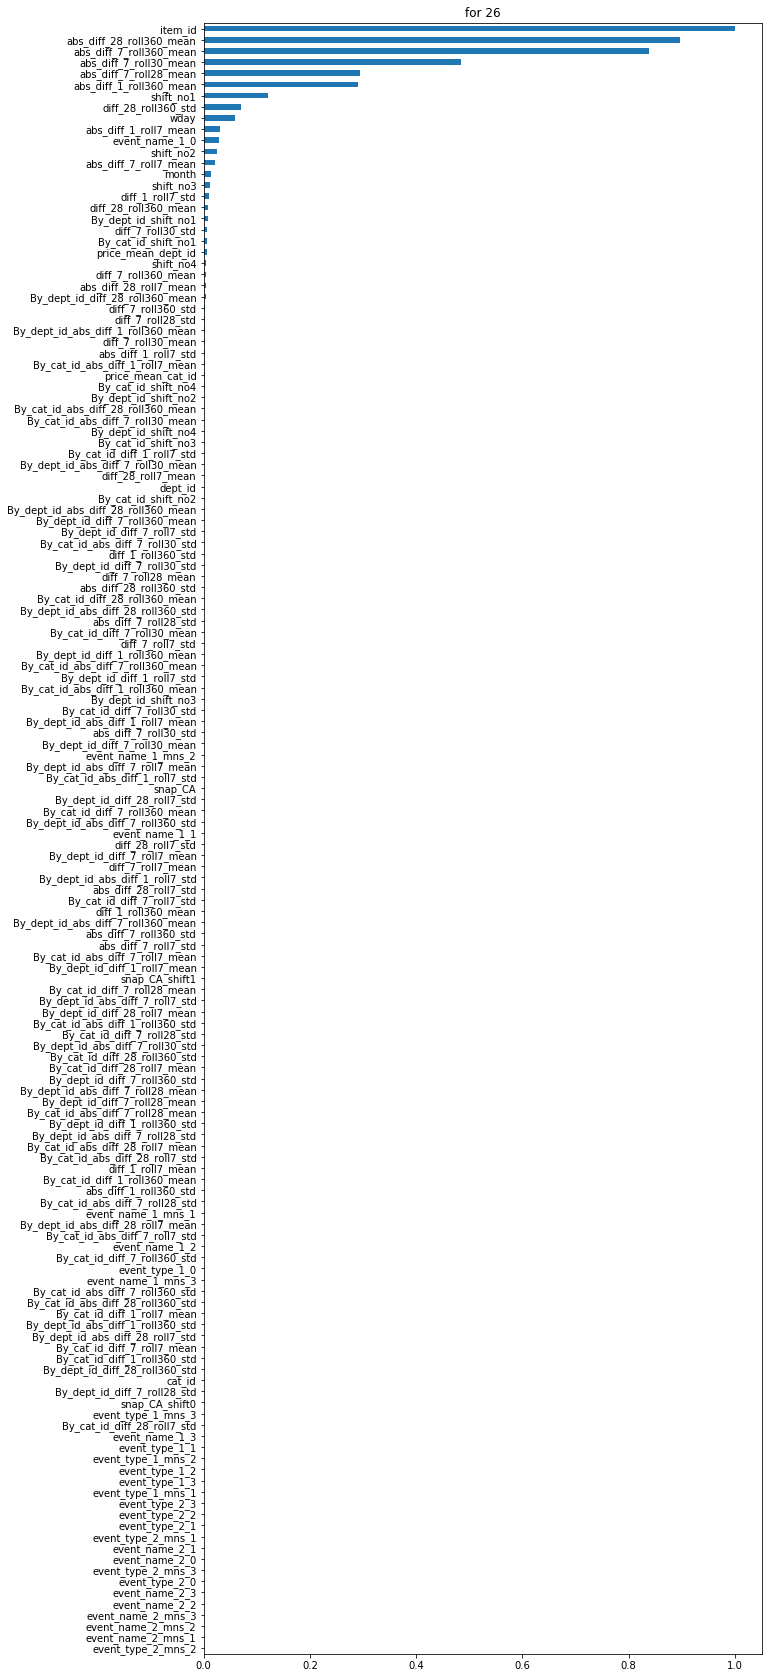

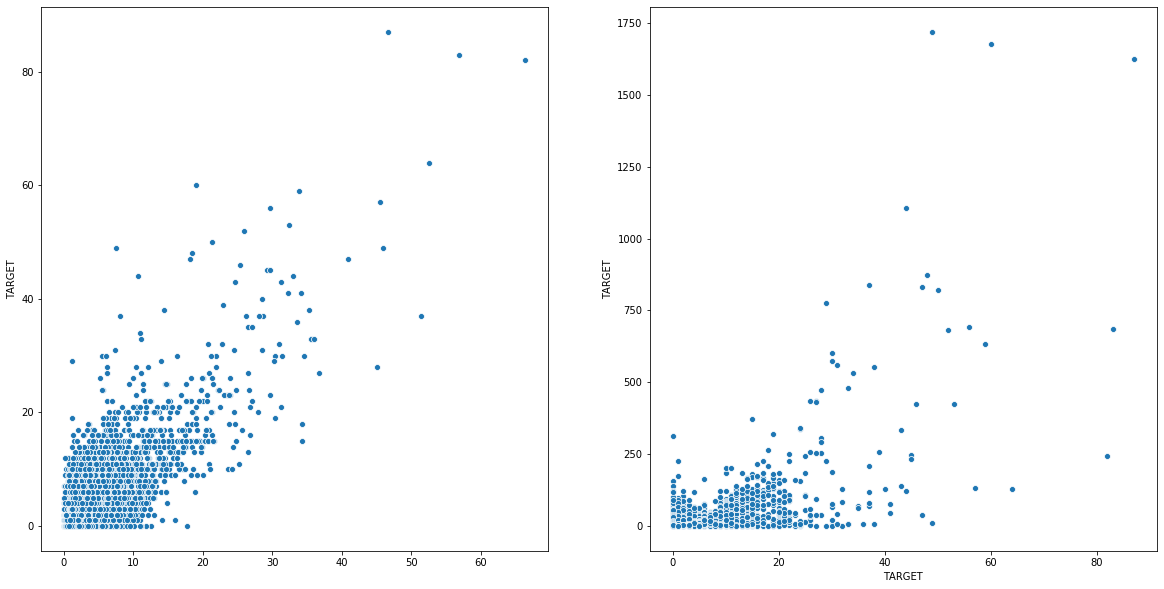


        #########################################
           ##############  28  ##############
        #########################################
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 2.08984	valid_1's rmse: 1.97347
[1000]	training's rmse: 2.01436	valid_1's rmse: 1.9437
Early stopping, best iteration is:
[1247]	training's rmse: 1.98934	valid_1's rmse: 1.94157


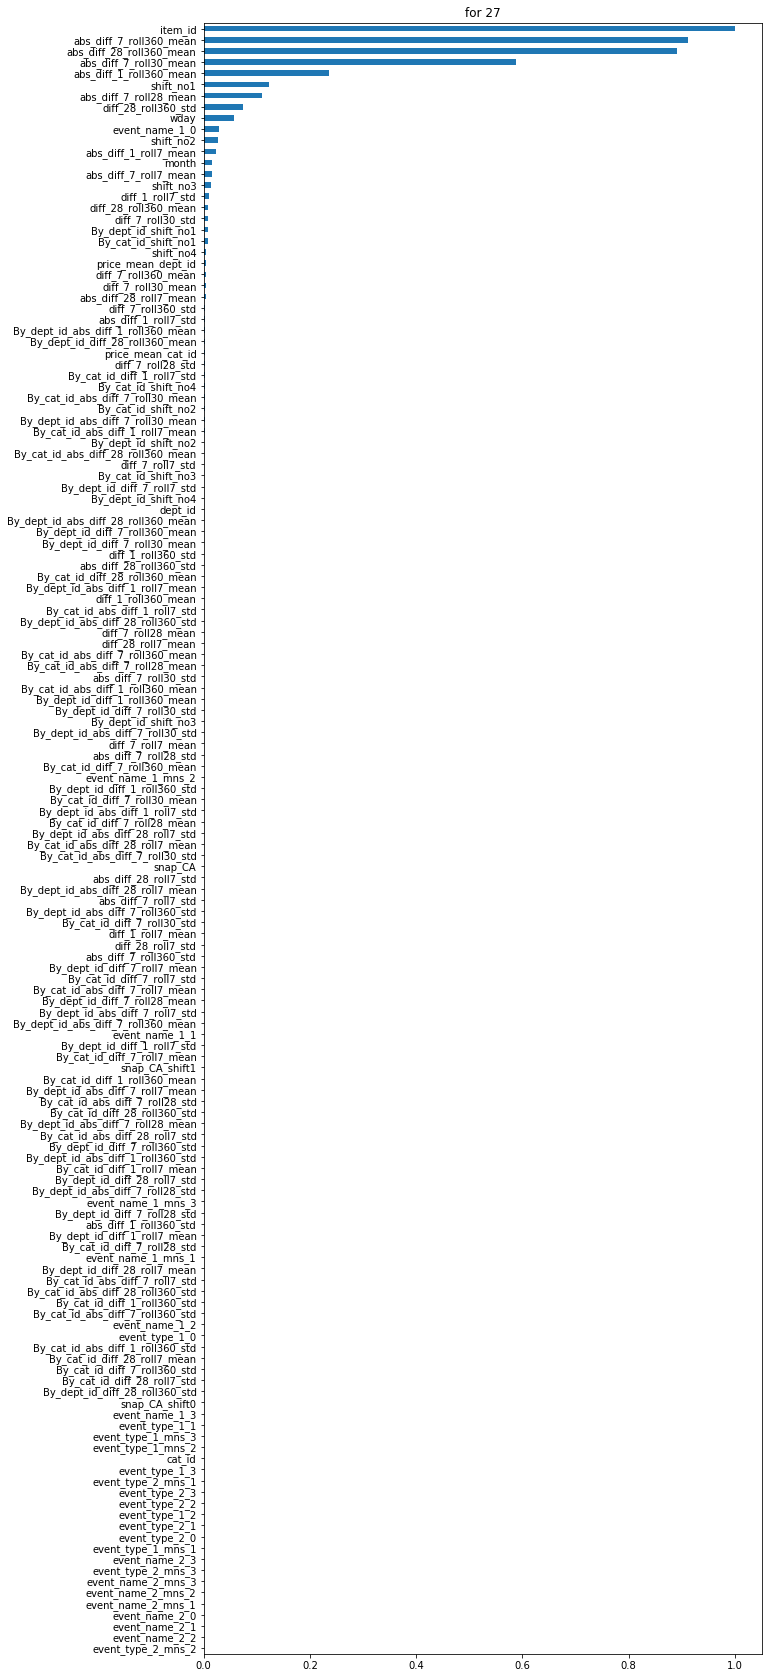

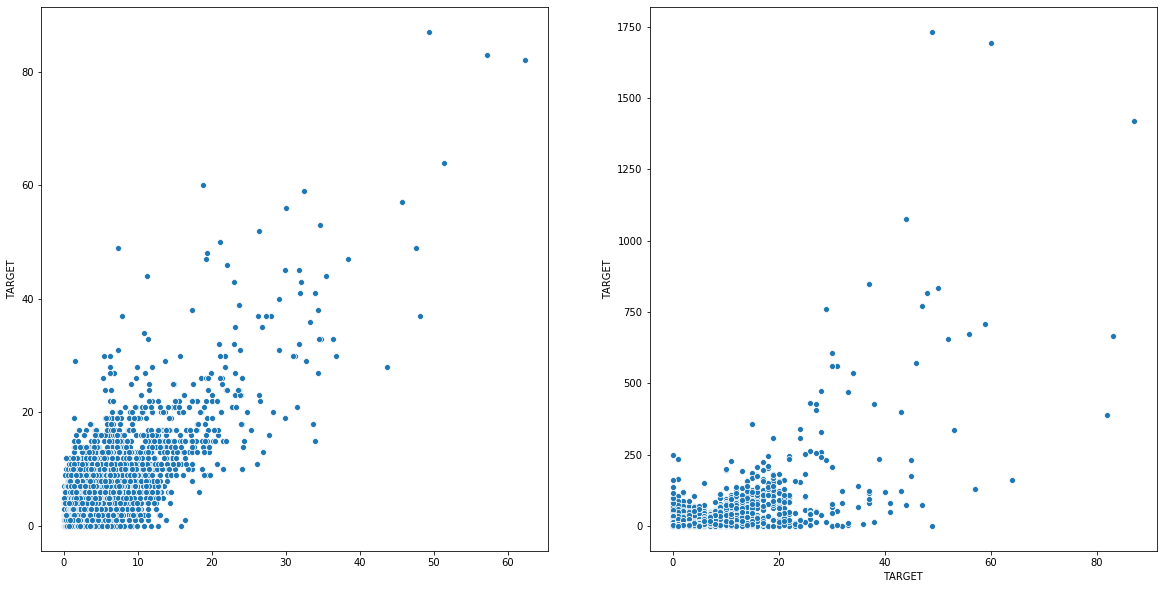

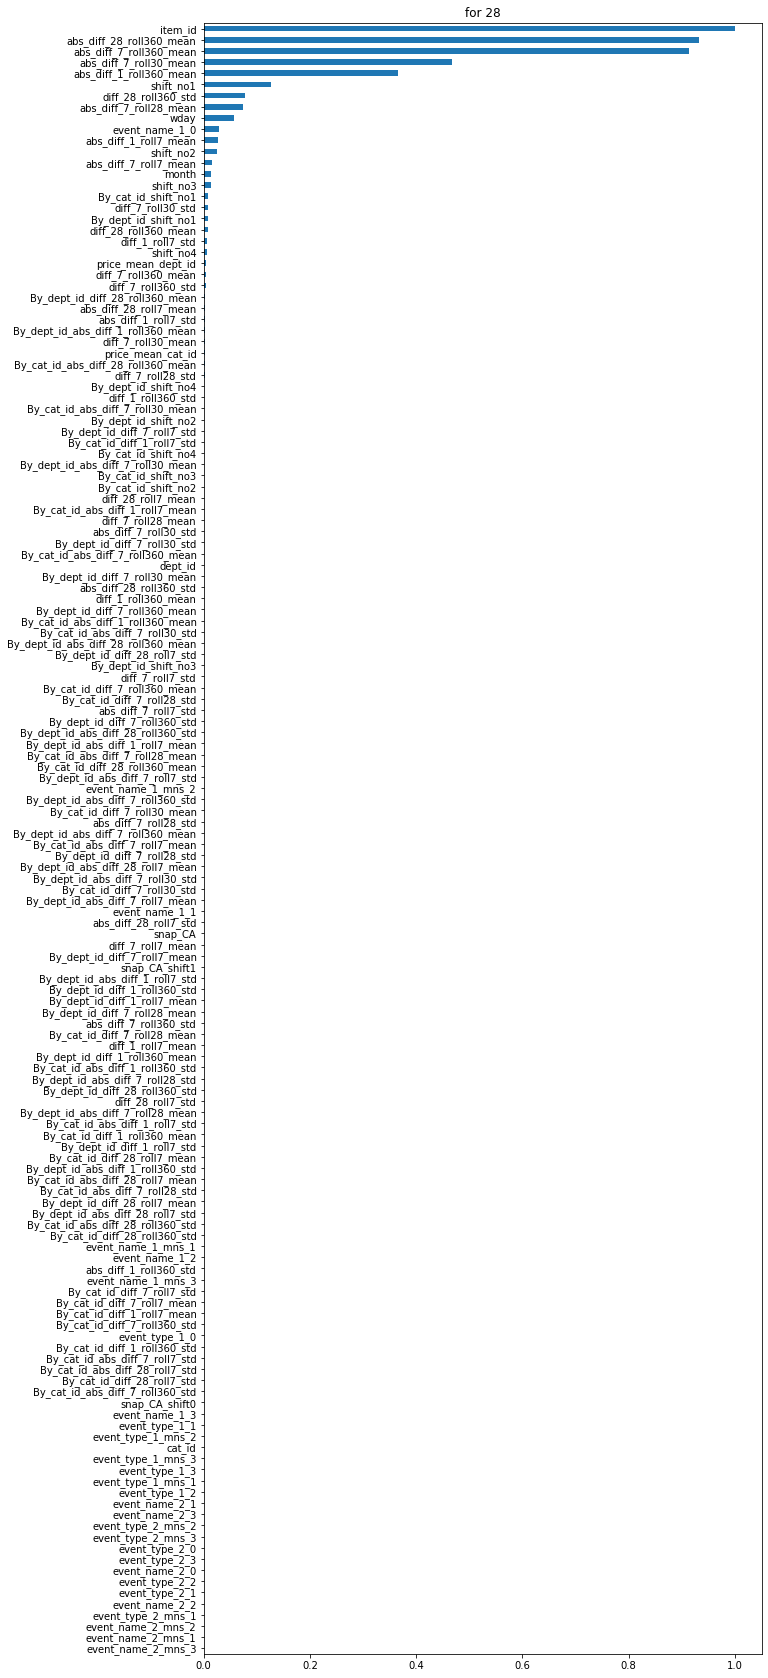

In [13]:
#'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'
_store='CA_1'

data, df, dfT = make_input(train_d_cols, _store)
train(data, df, dfT)

In [ ]:
def run_all(_store):
    global _store = _store
    lag=30
    
    train_d_cols = d_cols[-(lag+160+56):-lag]#+TARGET_D_COLS
    data, df, dfT = make_input(train_d_cols, _store)
    train(data, df, dfT)

In [ ]:
for _store in ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']:
    global _store = _store
    run_all(_store)